# DataCoLab Task Assignment

## Step 1: Data Preprocessing

In [ ]:
# import google drive to use gpu for this section
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q python-dotenv

In [ ]:
# Import libraries
import os
import re
import json
import time
import string
from tqdm import tqdm
from collections import Counter
import requests
from urllib.parse import urlencode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
# CONSTANTS
UNKNOWN_AUTHOR = 'Unknown'
UNKNOWN_PUBLICATION_DATE = 'Unknown'

#### load env variable

In [ ]:
_ = load_dotenv(find_dotenv())

### Load dataset from google drive

In [ ]:
# header for dataset
header = ['Wikipedia_Article_ID', 'Freebase_ID', 'Book_Title', 'Author',
          'Publication_Date', 'Book_Genres_(Freebase_ID:name_tuples)',
          'Plot_Summary']

# Load dataset from text file in google drive
file_path = 'drive/MyDrive/booksummaries.txt'
data = pd.read_csv(file_path, sep='\t', header=None,
                   names=header, encoding='utf-8')

### Load dataset from local system

In [ ]:
# # header for dataset
# header = ['Wikipedia_Article_ID', 'Freebase_ID', 'Book_Title', 'Author',
#           'Publication_date', 'Book_Genres_(Freebase_ID:name_tuples)',
#           'Plot_Summary']

# # Load dataset from text file in local system
# data = pd.read_csv('booksummaries.txt', sep='\t', header=None,
#                    names=header, encoding='utf-8')

In [ ]:
# Display sample of data
data.head()

,Wikipedia_Article_ID,Freebase_ID,Book_Title,Author,Publication_Date,Book_Genres_(Freebase_ID:name_tuples),Plot_Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [ ]:
# Display shape of data
print(f"Shape of dataset: {data.shape}")

Shape of dataset: (16559, 7)


### Preprocess Section

In [ ]:
# # Drop "Wikipedia article ID", "Freebase_ID" column cause that values are
# # unique and useless
# data = data.drop("Wikipedia_Article_ID", axis=1)
# data = data.drop("Freebase_ID", axis=1)

# Add "Index" column by reset it
data = data.reset_index()
data.rename(columns={'index': 'Index'}, inplace=True)

In [ ]:
# convert all genres values into tuple and remove Freebase_ID
for i in tqdm(range(len(data))):
    try:
        genres_dict = json.loads(
            data.loc[i, 'Book_Genres_(Freebase_ID:name_tuples)'])
        if isinstance(genres_dict, dict):
            data.at[i, 'Book_Genres_(Freebase_ID:name_tuples)'] = tuple(
                genres_dict.values())
        else:
            data.at[i, 'Book_Genres_(Freebase_ID:name_tuples)'] = np.nan
    # Handle NaN values and JSON decoding errors
    except (TypeError, json.JSONDecodeError):
        continue

data.rename(columns={'Book_Genres_(Freebase_ID:name_tuples)': 'Book_Genres'},
            inplace=True)

100%|██████████| 16559/16559 [00:01<00:00, 14719.71it/s]


In [ ]:
# Check the Nan value of all columns
print(data.isna().sum())

Index                      0
Wikipedia_Article_ID       0
Freebase_ID                0
Book_Title                 0
Author                   131
Publication_Date          50
Book_Genres             3718
Plot_Summary               0
dtype: int64


### Fill Author and Publication date missing values with Google Book API

In [ ]:
def clean_title(title):
    """
    Clean and sanitize a title for encoding in a URL query parameter.

    Parameters:
    title (str): The title to be cleaned and formatted.

    Returns:
    str: The cleaned and formatted title ready for encoding.

    The function performs the following steps to clean the title:
    1. Removes leading and trailing whitespaces.
    2. Removes special characters except for letters, digits, spaces, and specified punctuation signs.
    3. Removes extra whitespaces.

    Example:
    >>> title = "The //!@#Great Gatsby's   "
    >>> cleaned_title = clean_title(title)
    >>> print(cleaned_title)
    'The Great Gatsby's'
    """
    title = title.strip()
    title = ''.join(char if char.isalnum() or char.isspace() or char in
        ["'", "-", ",", ":", ";"] else ' ' for char in title)
    title = ' '.join(title.split())

    return title

In [ ]:
def get_book_info(title, author=None):
    """Fetches book information from the Google Books API for a given title and author.

    Args:
        title (str): The title of the book to search for.
        author (str, optional): The author of the book. If provided, the search query will be refined.

    Returns:
        dict: A dictionary containing book information (title, author, publication date)
            if found. Returns None if no results are found.

    Raises:
        Exception: Raises an exception if there's an error fetching data from the API.
    """

    api_key = os.getenv("GOOGLE_BOOKS_API_KEY")
    if not api_key:
      raise ValueError("Missing environment variable: GOOGLE_BOOKS_API_KEY")

    title = clean_title(title)

    query_params = {"q": title}
    if author:
      query_params["author"] = author

    url = f"https://www.googleapis.com/books/v1/volumes?{urlencode(query_params)}&maxResults=1&key={api_key}"

    try:
      response = requests.get(url)
      response.raise_for_status()  # Raise an exception for non-200 status codes
    except requests.exceptions.RequestException as e:
      raise Exception(f"Error fetching book information: {e}") from e

    data = response.json()
    if 'items' in data:
      book_data = data['items'][0]['volumeInfo']
      return {
        'title': book_data['title'],
        'author': book_data['authors'][0] if 'authors' in book_data else np.nan,
        'publication_date': book_data['publishedDate'] if 'publishedDate' in book_data else np.nan,
      }
    else:
      return None

In [ ]:
# Fill Author and Publication date missing values with Google Book API
for index, row in tqdm(data.iterrows()):
    # Check if either Author or Publication date is missing
    if pd.isnull(row['Author']) or pd.isnull(row['Publication_Date']):
        # Use the existing author if available, otherwise send None
        author = row['Author'] if not pd.isnull(row['Author']) else None
        book_info = get_book_info(row['Book_Title'], author)
        if book_info:
            data.at[index, 'Author'] = book_info['author']
            data.at[index, 'Publication_Date'] = book_info['publication_date']
        time.sleep(1)

16559it [03:48, 72.35it/s]


In [ ]:
# Check the Nan value of 'Author' and 'Publication_Date' columns
print(data.isna().sum())

Index                      0
Wikipedia_Article_ID       0
Freebase_ID                0
Book_Title                 0
Author                   131
Publication_Date          50
Book_Genres             3718
Plot_Summary               0
dtype: int64


In [ ]:
# Checkpoint 1 for to save data into drive
file_path = 'drive/MyDrive/checkpoint1_book_summaries.csv'
data.to_csv(file_path, sep='\t', index=False, encoding='utf-8')

In [ ]:
file_path = 'drive/MyDrive/checkpoint1_book_summaries.csv'
data = pd.read_csv(file_path, sep='\t', encoding='utf-8')

In [ ]:
def extract_year(pub_date):
    """
    Convert publication date to just the year
    (if it's in YYYY-MM-DD format)
    """
    if isinstance(pub_date, str) and '-' in pub_date:
        return pd.to_datetime(pub_date, errors='coerce').year
    elif isinstance(pub_date, str) and not pub_date.isdigit():
        if year_match := re.search(r'\d{4}', pub_date):
            return int(year_match.group())
        else:
            return np.nan
    return int(pub_date) if isinstance(pub_date, str) and pub_date.isdigit()\
        else np.nan

data['Publication_Year'] = data['Publication_Date'].apply(extract_year)

In [ ]:
# Remove duplicate rows
# Check for duplicates based on a unique identifier or key columns
duplicates = data.duplicated(subset=['Book_Title', 'Author'], keep='first')
print(f"Number of duplicate rows: {duplicates.sum()}")

# # Drop duplicates
# data = data.drop_duplicates(subset=['Book_Title', 'Author'], keep='first')

Number of duplicate rows: 55


In [ ]:
# text cleaning
# if get an error for this line, you must use `nltk.download()`
# command and download stopwords
# stop_words = set(stopwords.words('english'))


def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stop words
    # we don't remove stop words to get more accurate text in step 2
    # text = ' '.join([word for word in text.split()
    #                  if word not in stop_words])
    # Remove extra  before and after whitespace

    text = text.strip()
    # check if text is none
    text = text if text else np.nan

    return text


data['Cleaned_Summary'] = data['Plot_Summary'].apply(clean_text)

In [ ]:
print(f"Number of null Cleaned Summary rows:",
      len(data[data['Cleaned_Summary'].isnull()]))

# Drop rows where 'Cleaned_Summary' is NaN
data = data.dropna(subset=['Cleaned_Summary'])

Number of null Cleaned Summary rows: 5


In [ ]:
# summary length
data['Summary_Length'] = data['Cleaned_Summary']\
    .apply(lambda x: len(x.split()))

# Detect outliers in Summary_Length
Q1 = data['Summary_Length'].quantile(0.25)
Q3 = data['Summary_Length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Summary_Length'] < lower_bound) |
                (data['Summary_Length'] > upper_bound)]
print(f"Number of outliers in Summary Length: {outliers.shape[0]}")

# # Remove outliers
# data = data[(data['Summary Length'] >= lower_bound) &
#             (data['Summary Length'] <= upper_bound)]

Number of outliers in Summary Length: 958


In [ ]:
# Fill Author missing values with UNKNOWN_AUTHOR variable because
# We cannot put anyone's book under the name of another author
data['Author'].fillna(UNKNOWN_AUTHOR, inplace=True)

In [ ]:
# Fill missing values book generes based of other author's book
# this section of code is not good and fix just 2 rows:)))


def fill_missing_genres(df, num_modes):
    for author, group in tqdm(df.groupby('Author')):
        if author != UNKNOWN_AUTHOR:
            genres = [genre for genres in group['Book_Genres'] if
                      isinstance(genres, tuple) for genre in genres]
            if genres:
                mode_genres = [genre for genre, _ in Counter(genres)
                               .most_common(num_modes)]
                # We do this because normally can't assign tuple
                # and we get an error
                if len(df.loc[(df['Author'] == author) &
                       (df['Book_Genres'].isnull()), 'Book_Genres']) > 0:
                    for i in data.loc[(data['Author'] == author) &
                                      (data['Book_Genres'].isnull()),
                                      'Index'].values:
                        df.at[i, 'Book_Genres'] = tuple(mode_genres)

    return df


# Fill missing genres based on author with the 5 most common genres
data = fill_missing_genres(data, 5)

100%|██████████| 7062/7062 [00:00<00:00, 12017.33it/s]


In [ ]:
# Check the Nan value of 'Author' and 'Publication_Date' columns
print(data.isna().sum())

Index                      0
Wikipedia_Article_ID       0
Freebase_ID                0
Book_Title                 0
Author                     0
Publication_Date          50
Book_Genres             3718
Plot_Summary               0
Publication_Year          57
Cleaned_Summary            0
Summary_Length             0
dtype: int64


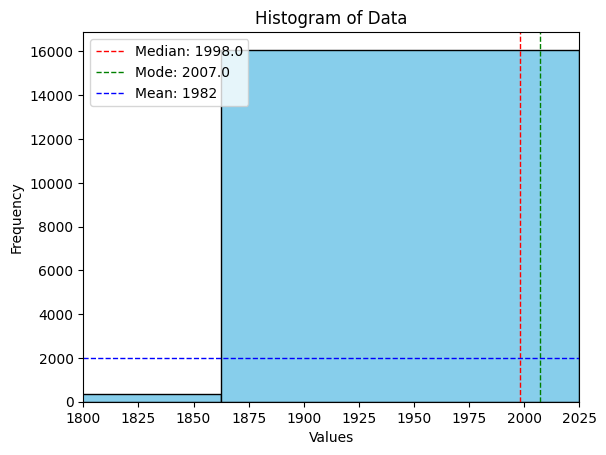

In [ ]:
# Plot a histogram to find out median is better for 'Publication_Year' or mode
median = data['Publication_Year'].median()
mode = data['Publication_Year'].mode()[0]
mean = int(data['Publication_Year'].mean())

plt.hist(data['Publication_Year'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Add markers for median and mode
plt.axvline(median, color='r', linestyle='dashed',
            linewidth=1, label=f'Median: {median}')
plt.axvline(mode, color='g', linestyle='dashed',
            linewidth=1, label=f'Mode: {mode}')
plt.axhline(mean, color='b', linestyle='dashed',
            linewidth=1, label=f'Mean: {mean}')
plt.xlim(1800, data['Publication_Year'].max())

plt.legend()
plt.show()

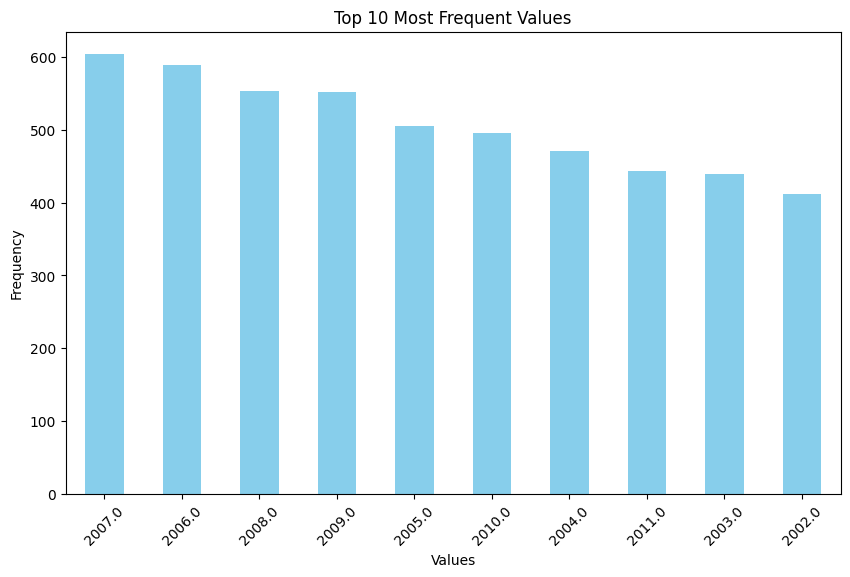

In [ ]:
# Calculate the frequency of each value
value_counts = data['Publication_Year'].value_counts()

# Get the top 10 most frequent values
top_values = value_counts.head(10)

# Plot a bar plot for the top 10 most frequent values
plt.figure(figsize=(10, 6))
top_values.plot(kind='bar', color='skyblue')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Values')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# fill Publication Year and Publication date missing value
# with mode of data based on Top 10 values plot
mean_year = int(data['Publication_Year'].mode()[0])
data['Publication_Year'].fillna(mean_year, inplace=True)
data['Publication_Date'].fillna(mean_year, inplace=True)

In [45]:
# Check the Nan value of all columns
print(data.isna().sum())

Index                      0
Wikipedia_Article_ID       0
Freebase_ID                0
Book_Title                 0
Author                     0
Publication_Date           0
Book_Genres             3718
Plot_Summary               0
Publication_Year           0
Cleaned_Summary            0
Summary_Length             0
dtype: int64


In [47]:
# Save cleaned data after preprocessing
file_path = 'drive/MyDrive/cleaned_book_summaries.csv'
data.to_csv(file_path, sep='\t', index=False, encoding='utf-8')

## Step 2: NLP Component

In [ ]:
# import google drive to use gpu for this section
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers torch rouge-score

  Preparing metadata (setup.py) ... done


In [ ]:
from tqdm import tqdm
import pandas as pd
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from rouge_score import rouge_scorer

In [ ]:
# Load pre-trained BART model and tokenizer, move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn',
                                          clean_up_tokenization_spaces=True)
model = BartForConditionalGeneration.from_pretrained(
    'facebook/bart-large-cnn').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [ ]:
# Load dataset from csv file from drive for google colab
file_path = 'drive/MyDrive/cleaned_book_summaries.csv'
data = pd.read_csv(file_path, sep='\t', encoding='utf-8')

In [ ]:
# # Load dataset from local csv file
# data = pd.read_csv('cleaned_book_summaries.csv', sep='\t', encoding='utf-8')

In [ ]:
def summarize_batch(texts, max_input_length=1024, max_output_length=75, num_beams=2, device='cpu'):
    """
    Summarizes a batch of input texts using the BART model.

    Args:
    texts (list of str): List of original texts to be summarized.
    max_input_length (int): Maximum number of tokens in the input text.
    max_output_length (int): Maximum number of tokens in the summarized text.
    num_beams (int): Number of beams for beam search.
    device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
    list of str: List of summarized texts.
    """
    # Tokenize and truncate the input to the max input length (batch processing)
    inputs = tokenizer(texts, return_tensors="pt", max_length=max_input_length, truncation=True, padding=True).to(device)

    # Generate the summary for the batch
    summary_ids = model.generate(
        inputs["input_ids"],
        num_beams=num_beams,  # Beam search for diversity
        max_length=max_output_length,  # Limit the length of the output summary
        early_stopping=True  # Stop when the model is confident in its answer
    )

    # Decode the generated tokens into a string (summary)
    return [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in summary_ids]


In [ ]:
# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [ ]:
# Example usage on a single text summary
sample_text = data.loc[12390, 'Cleaned_Summary']  # longest text in dataset
short_summary = summarize_batch([sample_text], device=device)[0]
print("Cleaned Summary lenght:", len(sample_text.split()))
print("Summarized Text lenght:", len(short_summary.split()))
print("Summarized Text:", short_summary)

Cleaned Summary lenght: 10317
Summarized Text lenght: 51
Summarized Text: Imriel and sidonie are on their way to the city of elua to confront queen ysandre about their relationship. They are met by a group of priests who declare their love to be genuine. The queen decides to treat their love like it does not exist and decides to disinherit them.


In [ ]:
# Compute ROUGE scores
scores = scorer.score(sample_text, short_summary)

# Print ROUGE scores
print("ROUGE-1: ", scores['rouge1'])
print("ROUGE-2: ", scores['rouge2'])
print("ROUGE-L: ", scores['rougeL'])


ROUGE-1:  Score(precision=1.0, recall=0.004935165473195278, fmeasure=0.009821858449687049)
ROUGE-2:  Score(precision=0.62, recall=0.0030000967773153972, fmeasure=0.0059712992391409035)
ROUGE-L:  Score(precision=0.8235294117647058, recall=0.004064253919101994, fmeasure=0.008088589311506982)


The ROUGE scores obtained for the longest text in the dataset provide us with valuable insights into the performance of summarization model. Below is an analysis of these results:

### **ROUGE-1:**
- **Precision = 1.0**: This indicates that 100% of the unigrams (individual words) in the summary are present in the original text. The summary is exclusively composed of words from the original.
- **Recall = 0.0049**: Only about 0.49% of the unigrams from the original text are included in the summary. This very low recall suggests the summary is extremely condensed.
- **F1-Score = 0.0098**: The harmonic mean between precision and recall is low due to the significant gap between the two. While the model captures every word it chooses with perfect precision, it includes very few words from the original.

### **ROUGE-2:**
- **Precision = 0.62**: This means 62% of the bigrams (pairs of consecutive words) in the summary are present in the original text. However, this isn't as high as the unigram precision, indicating that while individual words are captured well, their order might not be as well preserved.
- **Recall = 0.0030**: About 0.3% of the bigrams from the original text are present in the summary, which suggests that only a very tiny fraction of the original bigram content is captured.
- **F1-Score = 0.0060**: The F1 score is quite low due to the large gap between precision and recall, indicating that the summary may be missing important contextual sequences of words.

### **ROUGE-L:**
- **Precision = 0.824**: Around 82.4% of the longest common subsequences (LCS) between the summary and original text are preserved, which suggests the model does a reasonable job of maintaining word order for the parts of the original text it includes.
- **Recall = 0.0041**: Only 0.41% of the sequences from the original text appear in the summary, indicating that while the word order is preserved, a very small amount of content is actually included.
- **F1-Score = 0.0081**: The low F1 score again reflects the tension between high precision and low recall, meaning the model extracts sequences faithfully but covers only a tiny portion of the original text.

### **Interpretation:**
- **High precision, low recall**: Across all the ROUGE scores, precision is relatively high (especially for ROUGE-1), but recall is extremely low. This suggests that the model creates **very short summaries**, where most of the content is omitted, but what is included is perfectly selected.
- **Condensed summary**: Given the very low recall (~0.49% for ROUGE-1 and ~0.3% for ROUGE-2), it seems the summary is heavily reduced in length and content compared to the original text.
- **Bigram and sequence preservation**: While bigram precision and LCS precision are somewhat decent, the low recall shows that the summary may not be capturing much of the original context or detail.

### **Summary of Findings:**
- Your summarization model is **highly precise** in choosing words and maintaining word order from the original text, but it summarizes the text in a very condensed form, leading to a **low recall**.
- If you're aiming for **concise summaries**, this may be acceptable, but the summaries may be missing a lot of important content.
- If our goal is to generate **short, accurate summaries**, this level of compression may be ideal, aligning with our objective. On the other hand, if we aim to preserve more content from the original material, we might need to **increase the summary length** (adjusting `max_output_length`) or adjust the model parameters.

In [ ]:
# Example usage on a single text summary
sample_text = data.loc[0, 'Cleaned_Summary']
short_summary = summarize_batch([sample_text], device=device)[0]
print("Cleaned Summary lenght:", len(sample_text.split()))
print("Summarized Text lenght:", len(short_summary.split()))
print("Summarized Text:", short_summary)

Cleaned Summary lenght: 944
Summarized Text lenght: 65
Summarized Text: Old major the old boar on the manor farm calls the animals on the farm for a meeting where he compares the humans to parasites and teaches the animals a revolutionary song beasts of england when major dies two young pigs snowball and napoleon assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible mr jones from


In [ ]:
# Compute ROUGE scores
scores = scorer.score(sample_text, short_summary)

# Print ROUGE scores
print("ROUGE-1: ", scores['rouge1'])
print("ROUGE-2: ", scores['rouge2'])
print("ROUGE-L: ", scores['rougeL'])

ROUGE-1:  Score(precision=1.0, recall=0.06885593220338983, fmeasure=0.12884043607532208)
ROUGE-2:  Score(precision=1.0, recall=0.06786850477200425, fmeasure=0.12711022840119168)
ROUGE-L:  Score(precision=1.0, recall=0.06885593220338983, fmeasure=0.12884043607532208)


The obtained ROUGE scores provide some useful insights into the performance of the summarization model. Below is an analysis based on the provided scores:

### **ROUGE-1:**
- **Precision = 1.0**: This means 100% of the unigrams (individual words) in the summary are found in the original text. The summary doesn’t introduce any new words, only using words from the original.
- **Recall = 0.0689**: About 6.89% of the unigrams from the original text are present in the summary. This indicates that only a small portion of the original content is captured in the summary.
- **F1-Score = 0.1288**: The F1 score, which is the harmonic mean between precision and recall, reflects a balance between the two. While the precision is perfect, the low recall keeps the F1 score down.

### **ROUGE-2:**
- **Precision = 1.0**: All of the bigrams (pairs of consecutive words) in the summary are directly taken from the original text, so there is no deviation from the word order or word choice.
- **Recall = 0.0679**: Only about 6.79% of the bigrams from the original text are captured in the summary, meaning that very few sequences of two consecutive words are included.
- **F1-Score = 0.1271**: This score reflects the balance between the perfect precision and the low recall, showing that while the summary is accurate in terms of bigram usage, it captures only a small part of the original.

### **ROUGE-L:**
- **Precision = 1.0**: The longest common subsequences (LCS) in the summary are perfectly matched to those in the original text, so word order is faithfully preserved.
- **Recall = 0.0689**: Similar to ROUGE-1, only 6.89% of the sequences from the original text are included in the summary, highlighting how much of the original content is omitted.
- **F1-Score = 0.1288**: The F1 score indicates a decent balance between precision and recall, where precision is perfect but recall is quite low.

### **Interpretation:**
- **Perfect precision (1.0)**: The summary is highly faithful to the original text, as every word, bigram, and sequence in the summary appears in the original. There is no extraneous or erroneous content.
- **Low recall (~6.9%)**: The summary is very condensed, including less than 7% of the original content. This suggests that while the summary is accurate, it covers only a small portion of the original text.
- **F1-scores (~0.128)**: The F1-scores reflect the model’s high precision but low recall, meaning it does a good job of capturing the words and phrases it chooses but doesn’t include much of the original content.

### **Summary of Findings:**
- The model generates summaries that are **extremely precise**, ensuring that all words and sequences in the summary are drawn from the original text.
- However, the **low recall** indicates that the summaries omit a significant portion of the original content, making them highly condensed.
- If our goal is to generate **short, accurate summaries**, this level of compression may be ideal, aligning with our objective. On the other hand, if we aim to preserve more content from the original material, we might need to **increase the summary length** (adjusting `max_output_length`) or adjust the model parameters.

In [ ]:
def batch_summarization(df, batch_size=32, num_beams=2, device='cpu'):
    """
    Summarizes the text in batches to manage memory and computation, leveraging GPU and batching.

    Args:
    df (DataFrame): The input DataFrame containing the 'Cleaned Summary' column.
    batch_size (int): Number of rows to process in each batch.
    num_beams (int): Number of beams for beam search.
    device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
    DataFrame: The DataFrame with a new column 'Summarized_Text'.
    """
    # Ensure the new column exists
    df['Summarized_Text'] = ""

    for i in tqdm(range(0, len(df), batch_size)):
        batch_df = df.iloc[i:i+batch_size]
        texts = batch_df['Cleaned_Summary'].tolist()  # Extract the batch of texts
        summaries = summarize_batch(texts, num_beams=num_beams, device=device)  # Summarize the batch
        df.loc[batch_df.index, 'Summarized_Text'] = summaries  # Update the DataFrame with the summarized text

        print(f"Processed batch {i} to {i+batch_size}")

    return df

In [ ]:
# Summarize the text in batches
data = batch_summarization(data, batch_size=32, num_beams=2, device=device)

  0%|          | 1/518 [00:12<1:49:31, 12.71s/it]

Processed batch 0 to 32


  0%|          | 2/518 [00:25<1:50:12, 12.82s/it]

Processed batch 32 to 64


  1%|          | 3/518 [00:38<1:49:44, 12.79s/it]

Processed batch 64 to 96


  1%|          | 4/518 [00:50<1:48:23, 12.65s/it]

Processed batch 96 to 128


  1%|          | 5/518 [01:03<1:47:42, 12.60s/it]

Processed batch 128 to 160


  1%|          | 6/518 [01:15<1:46:46, 12.51s/it]

Processed batch 160 to 192


  1%|▏         | 7/518 [01:28<1:46:50, 12.54s/it]

Processed batch 192 to 224


  2%|▏         | 8/518 [01:40<1:46:42, 12.55s/it]

Processed batch 224 to 256


  2%|▏         | 9/518 [01:53<1:47:03, 12.62s/it]

Processed batch 256 to 288


  2%|▏         | 10/518 [02:06<1:46:28, 12.58s/it]

Processed batch 288 to 320


  2%|▏         | 11/518 [02:18<1:46:36, 12.62s/it]

Processed batch 320 to 352


  2%|▏         | 12/518 [02:31<1:45:56, 12.56s/it]

Processed batch 352 to 384


  3%|▎         | 13/518 [02:43<1:45:56, 12.59s/it]

Processed batch 384 to 416


  3%|▎         | 14/518 [02:56<1:45:24, 12.55s/it]

Processed batch 416 to 448


  3%|▎         | 15/518 [03:08<1:44:58, 12.52s/it]

Processed batch 448 to 480


  3%|▎         | 16/518 [03:21<1:44:27, 12.49s/it]

Processed batch 480 to 512


  3%|▎         | 17/518 [03:33<1:43:52, 12.44s/it]

Processed batch 512 to 544


  3%|▎         | 18/518 [03:46<1:43:50, 12.46s/it]

Processed batch 544 to 576


  4%|▎         | 19/518 [03:58<1:43:29, 12.44s/it]

Processed batch 576 to 608


  4%|▍         | 20/518 [04:11<1:44:38, 12.61s/it]

Processed batch 608 to 640


  4%|▍         | 21/518 [04:23<1:44:12, 12.58s/it]

Processed batch 640 to 672


  4%|▍         | 22/518 [04:36<1:44:03, 12.59s/it]

Processed batch 672 to 704


  4%|▍         | 23/518 [04:49<1:43:42, 12.57s/it]

Processed batch 704 to 736


  5%|▍         | 24/518 [05:01<1:43:48, 12.61s/it]

Processed batch 736 to 768


  5%|▍         | 25/518 [05:14<1:43:28, 12.59s/it]

Processed batch 768 to 800


  5%|▌         | 26/518 [05:27<1:43:41, 12.64s/it]

Processed batch 800 to 832


  5%|▌         | 27/518 [05:39<1:43:08, 12.60s/it]

Processed batch 832 to 864


  5%|▌         | 28/518 [05:52<1:43:03, 12.62s/it]

Processed batch 864 to 896


  6%|▌         | 29/518 [06:04<1:42:16, 12.55s/it]

Processed batch 896 to 928


  6%|▌         | 30/518 [06:17<1:41:44, 12.51s/it]

Processed batch 928 to 960


  6%|▌         | 31/518 [06:29<1:40:56, 12.44s/it]

Processed batch 960 to 992


  6%|▌         | 32/518 [06:41<1:40:35, 12.42s/it]

Processed batch 992 to 1024


  6%|▋         | 33/518 [06:54<1:41:01, 12.50s/it]

Processed batch 1024 to 1056


  7%|▋         | 34/518 [07:06<1:40:34, 12.47s/it]

Processed batch 1056 to 1088


  7%|▋         | 35/518 [07:19<1:40:30, 12.49s/it]

Processed batch 1088 to 1120


  7%|▋         | 36/518 [07:31<1:40:12, 12.47s/it]

Processed batch 1120 to 1152


  7%|▋         | 37/518 [07:44<1:40:17, 12.51s/it]

Processed batch 1152 to 1184


  7%|▋         | 38/518 [07:56<1:39:48, 12.48s/it]

Processed batch 1184 to 1216


  8%|▊         | 39/518 [08:09<1:40:01, 12.53s/it]

Processed batch 1216 to 1248


  8%|▊         | 40/518 [08:21<1:39:39, 12.51s/it]

Processed batch 1248 to 1280


  8%|▊         | 41/518 [08:34<1:40:18, 12.62s/it]

Processed batch 1280 to 1312


  8%|▊         | 42/518 [08:47<1:39:44, 12.57s/it]

Processed batch 1312 to 1344


  8%|▊         | 43/518 [08:59<1:39:44, 12.60s/it]

Processed batch 1344 to 1376


  8%|▊         | 44/518 [09:12<1:38:50, 12.51s/it]

Processed batch 1376 to 1408


  9%|▊         | 45/518 [09:24<1:38:24, 12.48s/it]

Processed batch 1408 to 1440


  9%|▉         | 46/518 [09:36<1:37:45, 12.43s/it]

Processed batch 1440 to 1472


  9%|▉         | 47/518 [09:49<1:37:33, 12.43s/it]

Processed batch 1472 to 1504


  9%|▉         | 48/518 [10:01<1:37:07, 12.40s/it]

Processed batch 1504 to 1536


  9%|▉         | 49/518 [10:14<1:37:14, 12.44s/it]

Processed batch 1536 to 1568


 10%|▉         | 50/518 [10:26<1:36:50, 12.42s/it]

Processed batch 1568 to 1600


 10%|▉         | 51/518 [10:39<1:36:54, 12.45s/it]

Processed batch 1600 to 1632


 10%|█         | 52/518 [10:51<1:36:37, 12.44s/it]

Processed batch 1632 to 1664


 10%|█         | 53/518 [11:03<1:36:23, 12.44s/it]

Processed batch 1664 to 1696


 10%|█         | 54/518 [11:16<1:36:38, 12.50s/it]

Processed batch 1696 to 1728


 11%|█         | 55/518 [11:28<1:36:13, 12.47s/it]

Processed batch 1728 to 1760


 11%|█         | 56/518 [11:41<1:36:12, 12.49s/it]

Processed batch 1760 to 1792


 11%|█         | 57/518 [11:53<1:35:50, 12.47s/it]

Processed batch 1792 to 1824


 11%|█         | 58/518 [12:06<1:35:47, 12.49s/it]

Processed batch 1824 to 1856


 11%|█▏        | 59/518 [12:18<1:35:11, 12.44s/it]

Processed batch 1856 to 1888


 12%|█▏        | 60/518 [12:31<1:35:10, 12.47s/it]

Processed batch 1888 to 1920


 12%|█▏        | 61/518 [12:43<1:34:22, 12.39s/it]

Processed batch 1920 to 1952


 12%|█▏        | 62/518 [12:56<1:34:38, 12.45s/it]

Processed batch 1952 to 1984


 12%|█▏        | 63/518 [13:08<1:33:58, 12.39s/it]

Processed batch 1984 to 2016


 12%|█▏        | 64/518 [13:20<1:34:01, 12.43s/it]

Processed batch 2016 to 2048


 13%|█▎        | 65/518 [13:33<1:33:38, 12.40s/it]

Processed batch 2048 to 2080


 13%|█▎        | 66/518 [13:45<1:33:44, 12.44s/it]

Processed batch 2080 to 2112


 13%|█▎        | 67/518 [13:58<1:33:29, 12.44s/it]

Processed batch 2112 to 2144


 13%|█▎        | 68/518 [14:10<1:33:35, 12.48s/it]

Processed batch 2144 to 2176


 13%|█▎        | 69/518 [14:23<1:33:19, 12.47s/it]

Processed batch 2176 to 2208


 14%|█▎        | 70/518 [14:35<1:33:00, 12.46s/it]

Processed batch 2208 to 2240


 14%|█▎        | 71/518 [14:48<1:33:06, 12.50s/it]

Processed batch 2240 to 2272


 14%|█▍        | 72/518 [15:00<1:32:42, 12.47s/it]

Processed batch 2272 to 2304


 14%|█▍        | 73/518 [15:13<1:32:46, 12.51s/it]

Processed batch 2304 to 2336


 14%|█▍        | 74/518 [15:25<1:32:24, 12.49s/it]

Processed batch 2336 to 2368


 14%|█▍        | 75/518 [15:38<1:32:18, 12.50s/it]

Processed batch 2368 to 2400


 15%|█▍        | 76/518 [15:50<1:31:40, 12.45s/it]

Processed batch 2400 to 2432


 15%|█▍        | 77/518 [16:02<1:31:17, 12.42s/it]

Processed batch 2432 to 2464


 15%|█▌        | 78/518 [16:15<1:30:40, 12.37s/it]

Processed batch 2464 to 2496


 15%|█▌        | 79/518 [16:27<1:30:32, 12.38s/it]

Processed batch 2496 to 2528


 15%|█▌        | 80/518 [16:39<1:30:14, 12.36s/it]

Processed batch 2528 to 2560


 16%|█▌        | 81/518 [16:52<1:30:19, 12.40s/it]

Processed batch 2560 to 2592


 16%|█▌        | 82/518 [17:04<1:29:58, 12.38s/it]

Processed batch 2592 to 2624


 16%|█▌        | 83/518 [17:17<1:30:07, 12.43s/it]

Processed batch 2624 to 2656


 16%|█▌        | 84/518 [17:29<1:30:03, 12.45s/it]

Processed batch 2656 to 2688


 16%|█▋        | 85/518 [17:42<1:29:38, 12.42s/it]

Processed batch 2688 to 2720


 17%|█▋        | 86/518 [17:54<1:29:45, 12.47s/it]

Processed batch 2720 to 2752


 17%|█▋        | 87/518 [18:07<1:29:26, 12.45s/it]

Processed batch 2752 to 2784


 17%|█▋        | 88/518 [18:19<1:29:43, 12.52s/it]

Processed batch 2784 to 2816


 17%|█▋        | 89/518 [18:32<1:29:22, 12.50s/it]

Processed batch 2816 to 2848


 17%|█▋        | 90/518 [18:44<1:29:00, 12.48s/it]

Processed batch 2848 to 2880


 18%|█▊        | 91/518 [18:56<1:28:19, 12.41s/it]

Processed batch 2880 to 2912


 18%|█▊        | 92/518 [19:09<1:28:00, 12.39s/it]

Processed batch 2912 to 2944


 18%|█▊        | 93/518 [19:21<1:27:30, 12.35s/it]

Processed batch 2944 to 2976


 18%|█▊        | 94/518 [19:33<1:27:32, 12.39s/it]

Processed batch 2976 to 3008


 18%|█▊        | 95/518 [19:46<1:27:14, 12.38s/it]

Processed batch 3008 to 3040


 19%|█▊        | 96/518 [19:58<1:27:14, 12.40s/it]

Processed batch 3040 to 3072


 19%|█▊        | 97/518 [20:11<1:26:58, 12.40s/it]

Processed batch 3072 to 3104


 19%|█▉        | 98/518 [20:23<1:27:09, 12.45s/it]

Processed batch 3104 to 3136


 19%|█▉        | 99/518 [20:36<1:26:55, 12.45s/it]

Processed batch 3136 to 3168


 19%|█▉        | 100/518 [20:48<1:27:10, 12.51s/it]

Processed batch 3168 to 3200


 19%|█▉        | 101/518 [21:01<1:26:45, 12.48s/it]

Processed batch 3200 to 3232


 20%|█▉        | 102/518 [21:09<1:18:11, 11.28s/it]

Processed batch 3232 to 3264


 20%|█▉        | 103/518 [21:22<1:20:02, 11.57s/it]

Processed batch 3264 to 3296


 20%|██        | 104/518 [21:34<1:22:18, 11.93s/it]

Processed batch 3296 to 3328


 20%|██        | 105/518 [21:47<1:23:00, 12.06s/it]

Processed batch 3328 to 3360


 20%|██        | 106/518 [21:59<1:23:53, 12.22s/it]

Processed batch 3360 to 3392


 21%|██        | 107/518 [22:12<1:24:07, 12.28s/it]

Processed batch 3392 to 3424


 21%|██        | 108/518 [22:24<1:24:11, 12.32s/it]

Processed batch 3424 to 3456


 21%|██        | 109/518 [22:37<1:24:30, 12.40s/it]

Processed batch 3456 to 3488


 21%|██        | 110/518 [22:49<1:24:16, 12.39s/it]

Processed batch 3488 to 3520


 21%|██▏       | 111/518 [23:01<1:22:31, 12.17s/it]

Processed batch 3520 to 3552


 22%|██▏       | 112/518 [23:13<1:22:39, 12.21s/it]

Processed batch 3552 to 3584


 22%|██▏       | 113/518 [23:25<1:23:02, 12.30s/it]

Processed batch 3584 to 3616


 22%|██▏       | 114/518 [23:38<1:22:43, 12.29s/it]

Processed batch 3616 to 3648


 22%|██▏       | 115/518 [23:50<1:22:54, 12.34s/it]

Processed batch 3648 to 3680


 22%|██▏       | 116/518 [24:03<1:22:47, 12.36s/it]

Processed batch 3680 to 3712


 23%|██▎       | 117/518 [24:15<1:23:05, 12.43s/it]

Processed batch 3712 to 3744


 23%|██▎       | 118/518 [24:28<1:22:50, 12.43s/it]

Processed batch 3744 to 3776


 23%|██▎       | 119/518 [24:40<1:22:59, 12.48s/it]

Processed batch 3776 to 3808


 23%|██▎       | 120/518 [24:53<1:22:47, 12.48s/it]

Processed batch 3808 to 3840


 23%|██▎       | 121/518 [25:05<1:22:47, 12.51s/it]

Processed batch 3840 to 3872


 24%|██▎       | 122/518 [25:18<1:22:31, 12.50s/it]

Processed batch 3872 to 3904


 24%|██▎       | 123/518 [25:30<1:22:34, 12.54s/it]

Processed batch 3904 to 3936


 24%|██▍       | 124/518 [25:43<1:22:11, 12.52s/it]

Processed batch 3936 to 3968


 24%|██▍       | 125/518 [25:56<1:22:39, 12.62s/it]

Processed batch 3968 to 4000


 24%|██▍       | 126/518 [26:08<1:21:46, 12.52s/it]

Processed batch 4000 to 4032


 25%|██▍       | 127/518 [26:20<1:21:09, 12.45s/it]

Processed batch 4032 to 4064


 25%|██▍       | 128/518 [26:33<1:20:55, 12.45s/it]

Processed batch 4064 to 4096


 25%|██▍       | 129/518 [26:45<1:20:21, 12.40s/it]

Processed batch 4096 to 4128


 25%|██▌       | 130/518 [26:58<1:20:24, 12.43s/it]

Processed batch 4128 to 4160


 25%|██▌       | 131/518 [27:10<1:20:04, 12.42s/it]

Processed batch 4160 to 4192


 25%|██▌       | 132/518 [27:22<1:20:06, 12.45s/it]

Processed batch 4192 to 4224


 26%|██▌       | 133/518 [27:35<1:19:49, 12.44s/it]

Processed batch 4224 to 4256


 26%|██▌       | 134/518 [27:47<1:19:44, 12.46s/it]

Processed batch 4256 to 4288


 26%|██▌       | 135/518 [28:00<1:19:22, 12.43s/it]

Processed batch 4288 to 4320


 26%|██▋       | 136/518 [28:12<1:19:37, 12.51s/it]

Processed batch 4320 to 4352


 26%|██▋       | 137/518 [28:25<1:19:13, 12.48s/it]

Processed batch 4352 to 4384


 27%|██▋       | 138/518 [28:37<1:19:11, 12.50s/it]

Processed batch 4384 to 4416


 27%|██▋       | 139/518 [28:50<1:18:40, 12.45s/it]

Processed batch 4416 to 4448


 27%|██▋       | 140/518 [29:02<1:18:26, 12.45s/it]

Processed batch 4448 to 4480


 27%|██▋       | 141/518 [29:14<1:17:46, 12.38s/it]

Processed batch 4480 to 4512


 27%|██▋       | 142/518 [29:27<1:17:37, 12.39s/it]

Processed batch 4512 to 4544


 28%|██▊       | 143/518 [29:39<1:17:14, 12.36s/it]

Processed batch 4544 to 4576


 28%|██▊       | 144/518 [29:52<1:17:22, 12.41s/it]

Processed batch 4576 to 4608


 28%|██▊       | 145/518 [30:04<1:16:59, 12.39s/it]

Processed batch 4608 to 4640


 28%|██▊       | 146/518 [30:17<1:17:36, 12.52s/it]

Processed batch 4640 to 4672


 28%|██▊       | 147/518 [30:29<1:17:26, 12.52s/it]

Processed batch 4672 to 4704


 29%|██▊       | 148/518 [30:42<1:17:05, 12.50s/it]

Processed batch 4704 to 4736


 29%|██▉       | 149/518 [30:54<1:16:42, 12.47s/it]

Processed batch 4736 to 4768


 29%|██▉       | 150/518 [31:06<1:15:59, 12.39s/it]

Processed batch 4768 to 4800


 29%|██▉       | 151/518 [31:16<1:10:46, 11.57s/it]

Processed batch 4800 to 4832


 29%|██▉       | 152/518 [31:28<1:11:56, 11.79s/it]

Processed batch 4832 to 4864


 30%|██▉       | 153/518 [31:41<1:13:04, 12.01s/it]

Processed batch 4864 to 4896


 30%|██▉       | 154/518 [31:53<1:13:34, 12.13s/it]

Processed batch 4896 to 4928


 30%|██▉       | 155/518 [32:06<1:14:05, 12.25s/it]

Processed batch 4928 to 4960


 30%|███       | 156/518 [32:18<1:14:07, 12.29s/it]

Processed batch 4960 to 4992


 30%|███       | 157/518 [32:31<1:14:22, 12.36s/it]

Processed batch 4992 to 5024


 31%|███       | 158/518 [32:43<1:14:12, 12.37s/it]

Processed batch 5024 to 5056


 31%|███       | 159/518 [32:55<1:14:03, 12.38s/it]

Processed batch 5056 to 5088


 31%|███       | 160/518 [33:08<1:14:11, 12.43s/it]

Processed batch 5088 to 5120


 31%|███       | 161/518 [33:20<1:13:28, 12.35s/it]

Processed batch 5120 to 5152


 31%|███▏      | 162/518 [33:33<1:13:19, 12.36s/it]

Processed batch 5152 to 5184


 31%|███▏      | 163/518 [33:45<1:12:51, 12.32s/it]

Processed batch 5184 to 5216


 32%|███▏      | 164/518 [33:57<1:12:53, 12.35s/it]

Processed batch 5216 to 5248


 32%|███▏      | 165/518 [34:10<1:12:38, 12.35s/it]

Processed batch 5248 to 5280


 32%|███▏      | 166/518 [34:22<1:12:49, 12.41s/it]

Processed batch 5280 to 5312


 32%|███▏      | 167/518 [34:35<1:13:09, 12.51s/it]

Processed batch 5312 to 5344


 32%|███▏      | 168/518 [34:47<1:13:00, 12.52s/it]

Processed batch 5344 to 5376


 33%|███▎      | 169/518 [35:00<1:12:35, 12.48s/it]

Processed batch 5376 to 5408


 33%|███▎      | 170/518 [35:12<1:12:16, 12.46s/it]

Processed batch 5408 to 5440


 33%|███▎      | 171/518 [35:25<1:12:04, 12.46s/it]

Processed batch 5440 to 5472


 33%|███▎      | 172/518 [35:37<1:11:42, 12.43s/it]

Processed batch 5472 to 5504


 33%|███▎      | 173/518 [35:50<1:11:43, 12.47s/it]

Processed batch 5504 to 5536


 34%|███▎      | 174/518 [36:00<1:07:43, 11.81s/it]

Processed batch 5536 to 5568


 34%|███▍      | 175/518 [36:12<1:08:22, 11.96s/it]

Processed batch 5568 to 5600


 34%|███▍      | 176/518 [36:24<1:08:39, 12.05s/it]

Processed batch 5600 to 5632


 34%|███▍      | 177/518 [36:37<1:09:02, 12.15s/it]

Processed batch 5632 to 5664


 34%|███▍      | 178/518 [36:49<1:09:10, 12.21s/it]

Processed batch 5664 to 5696


 35%|███▍      | 179/518 [37:02<1:09:32, 12.31s/it]

Processed batch 5696 to 5728


 35%|███▍      | 180/518 [37:14<1:09:28, 12.33s/it]

Processed batch 5728 to 5760


 35%|███▍      | 181/518 [37:26<1:09:21, 12.35s/it]

Processed batch 5760 to 5792


 35%|███▌      | 182/518 [37:39<1:09:22, 12.39s/it]

Processed batch 5792 to 5824


 35%|███▌      | 183/518 [37:51<1:09:10, 12.39s/it]

Processed batch 5824 to 5856


 36%|███▌      | 184/518 [38:04<1:09:15, 12.44s/it]

Processed batch 5856 to 5888


 36%|███▌      | 185/518 [38:16<1:09:00, 12.43s/it]

Processed batch 5888 to 5920


 36%|███▌      | 186/518 [38:29<1:08:56, 12.46s/it]

Processed batch 5920 to 5952


 36%|███▌      | 187/518 [38:41<1:08:16, 12.38s/it]

Processed batch 5952 to 5984


 36%|███▋      | 188/518 [38:53<1:08:00, 12.37s/it]

Processed batch 5984 to 6016


 36%|███▋      | 189/518 [39:06<1:07:52, 12.38s/it]

Processed batch 6016 to 6048


 37%|███▋      | 190/518 [39:18<1:07:24, 12.33s/it]

Processed batch 6048 to 6080


 37%|███▋      | 191/518 [39:30<1:07:23, 12.36s/it]

Processed batch 6080 to 6112


 37%|███▋      | 192/518 [39:43<1:07:03, 12.34s/it]

Processed batch 6112 to 6144


 37%|███▋      | 193/518 [39:55<1:07:00, 12.37s/it]

Processed batch 6144 to 6176


 37%|███▋      | 194/518 [40:07<1:06:41, 12.35s/it]

Processed batch 6176 to 6208


 38%|███▊      | 195/518 [40:19<1:05:28, 12.16s/it]

Processed batch 6208 to 6240


 38%|███▊      | 196/518 [40:32<1:05:34, 12.22s/it]

Processed batch 6240 to 6272


 38%|███▊      | 197/518 [40:44<1:05:55, 12.32s/it]

Processed batch 6272 to 6304


 38%|███▊      | 198/518 [40:56<1:05:46, 12.33s/it]

Processed batch 6304 to 6336


 38%|███▊      | 199/518 [41:09<1:05:47, 12.37s/it]

Processed batch 6336 to 6368


 39%|███▊      | 200/518 [41:21<1:05:18, 12.32s/it]

Processed batch 6368 to 6400


 39%|███▉      | 201/518 [41:33<1:04:49, 12.27s/it]

Processed batch 6400 to 6432


 39%|███▉      | 202/518 [41:46<1:04:55, 12.33s/it]

Processed batch 6432 to 6464


 39%|███▉      | 203/518 [41:58<1:04:30, 12.29s/it]

Processed batch 6464 to 6496


 39%|███▉      | 204/518 [42:10<1:04:37, 12.35s/it]

Processed batch 6496 to 6528


 40%|███▉      | 205/518 [42:23<1:04:24, 12.35s/it]

Processed batch 6528 to 6560


 40%|███▉      | 206/518 [42:35<1:04:23, 12.38s/it]

Processed batch 6560 to 6592


 40%|███▉      | 207/518 [42:48<1:04:06, 12.37s/it]

Processed batch 6592 to 6624


 40%|████      | 208/518 [43:00<1:04:12, 12.43s/it]

Processed batch 6624 to 6656


 40%|████      | 209/518 [43:13<1:03:54, 12.41s/it]

Processed batch 6656 to 6688


 41%|████      | 210/518 [43:25<1:04:04, 12.48s/it]

Processed batch 6688 to 6720


 41%|████      | 211/518 [43:38<1:03:39, 12.44s/it]

Processed batch 6720 to 6752


 41%|████      | 212/518 [43:50<1:03:37, 12.48s/it]

Processed batch 6752 to 6784


 41%|████      | 213/518 [44:02<1:03:09, 12.42s/it]

Processed batch 6784 to 6816


 41%|████▏     | 214/518 [44:15<1:02:49, 12.40s/it]

Processed batch 6816 to 6848


 42%|████▏     | 215/518 [44:27<1:02:15, 12.33s/it]

Processed batch 6848 to 6880


 42%|████▏     | 216/518 [44:39<1:02:11, 12.35s/it]

Processed batch 6880 to 6912


 42%|████▏     | 217/518 [44:52<1:01:53, 12.34s/it]

Processed batch 6912 to 6944


 42%|████▏     | 218/518 [45:04<1:01:39, 12.33s/it]

Processed batch 6944 to 6976


 42%|████▏     | 219/518 [45:16<1:01:45, 12.39s/it]

Processed batch 6976 to 7008


 42%|████▏     | 220/518 [45:29<1:01:26, 12.37s/it]

Processed batch 7008 to 7040


 43%|████▎     | 221/518 [45:41<1:01:26, 12.41s/it]

Processed batch 7040 to 7072


 43%|████▎     | 222/518 [45:54<1:01:06, 12.39s/it]

Processed batch 7072 to 7104


 43%|████▎     | 223/518 [46:06<1:01:07, 12.43s/it]

Processed batch 7104 to 7136


 43%|████▎     | 224/518 [46:19<1:00:49, 12.41s/it]

Processed batch 7136 to 7168


 43%|████▎     | 225/518 [46:31<1:00:50, 12.46s/it]

Processed batch 7168 to 7200


 44%|████▎     | 226/518 [46:43<1:00:28, 12.43s/it]

Processed batch 7200 to 7232


 44%|████▍     | 227/518 [46:56<1:00:20, 12.44s/it]

Processed batch 7232 to 7264


 44%|████▍     | 228/518 [47:08<59:49, 12.38s/it]  

Processed batch 7264 to 7296


 44%|████▍     | 229/518 [47:20<59:13, 12.29s/it]

Processed batch 7296 to 7328


 44%|████▍     | 230/518 [47:32<58:36, 12.21s/it]

Processed batch 7328 to 7360


 45%|████▍     | 231/518 [47:45<58:56, 12.32s/it]

Processed batch 7360 to 7392


 45%|████▍     | 232/518 [47:57<59:01, 12.38s/it]

Processed batch 7392 to 7424


 45%|████▍     | 233/518 [48:10<58:48, 12.38s/it]

Processed batch 7424 to 7456


 45%|████▌     | 234/518 [48:22<58:48, 12.42s/it]

Processed batch 7456 to 7488


 45%|████▌     | 235/518 [48:35<58:28, 12.40s/it]

Processed batch 7488 to 7520


 46%|████▌     | 236/518 [48:47<58:33, 12.46s/it]

Processed batch 7520 to 7552


 46%|████▌     | 237/518 [49:00<58:09, 12.42s/it]

Processed batch 7552 to 7584


 46%|████▌     | 238/518 [49:12<57:54, 12.41s/it]

Processed batch 7584 to 7616


 46%|████▌     | 239/518 [49:24<57:23, 12.34s/it]

Processed batch 7616 to 7648


 46%|████▋     | 240/518 [49:36<57:05, 12.32s/it]

Processed batch 7648 to 7680


 47%|████▋     | 241/518 [49:49<56:44, 12.29s/it]

Processed batch 7680 to 7712


 47%|████▋     | 242/518 [50:01<56:28, 12.28s/it]

Processed batch 7712 to 7744


 47%|████▋     | 243/518 [50:13<56:30, 12.33s/it]

Processed batch 7744 to 7776


 47%|████▋     | 244/518 [50:26<56:19, 12.34s/it]

Processed batch 7776 to 7808


 47%|████▋     | 245/518 [50:38<56:21, 12.39s/it]

Processed batch 7808 to 7840


 47%|████▋     | 246/518 [50:50<56:00, 12.36s/it]

Processed batch 7840 to 7872


 48%|████▊     | 247/518 [51:03<56:02, 12.41s/it]

Processed batch 7872 to 7904


 48%|████▊     | 248/518 [51:15<55:44, 12.39s/it]

Processed batch 7904 to 7936


 48%|████▊     | 249/518 [51:28<55:28, 12.37s/it]

Processed batch 7936 to 7968


 48%|████▊     | 250/518 [51:40<55:31, 12.43s/it]

Processed batch 7968 to 8000


 48%|████▊     | 251/518 [51:53<55:15, 12.42s/it]

Processed batch 8000 to 8032


 49%|████▊     | 252/518 [52:05<55:08, 12.44s/it]

Processed batch 8032 to 8064


 49%|████▉     | 253/518 [52:17<54:42, 12.39s/it]

Processed batch 8064 to 8096


 49%|████▉     | 254/518 [52:30<54:38, 12.42s/it]

Processed batch 8096 to 8128


 49%|████▉     | 255/518 [52:42<54:10, 12.36s/it]

Processed batch 8128 to 8160


 49%|████▉     | 256/518 [52:51<49:07, 11.25s/it]

Processed batch 8160 to 8192


 50%|████▉     | 257/518 [53:03<49:51, 11.46s/it]

Processed batch 8192 to 8224


 50%|████▉     | 258/518 [53:15<51:03, 11.78s/it]

Processed batch 8224 to 8256


 50%|█████     | 259/518 [53:28<51:34, 11.95s/it]

Processed batch 8256 to 8288


 50%|█████     | 260/518 [53:40<51:52, 12.06s/it]

Processed batch 8288 to 8320


 50%|█████     | 261/518 [53:52<52:05, 12.16s/it]

Processed batch 8320 to 8352


 51%|█████     | 262/518 [54:04<51:54, 12.17s/it]

Processed batch 8352 to 8384


 51%|█████     | 263/518 [54:17<51:53, 12.21s/it]

Processed batch 8384 to 8416


 51%|█████     | 264/518 [54:29<51:43, 12.22s/it]

Processed batch 8416 to 8448


 51%|█████     | 265/518 [54:41<51:45, 12.27s/it]

Processed batch 8448 to 8480


 51%|█████▏    | 266/518 [54:54<51:30, 12.26s/it]

Processed batch 8480 to 8512


 52%|█████▏    | 267/518 [55:06<51:37, 12.34s/it]

Processed batch 8512 to 8544


 52%|█████▏    | 268/518 [55:18<51:24, 12.34s/it]

Processed batch 8544 to 8576


 52%|█████▏    | 269/518 [55:31<51:23, 12.38s/it]

Processed batch 8576 to 8608


 52%|█████▏    | 270/518 [55:43<51:03, 12.35s/it]

Processed batch 8608 to 8640


 52%|█████▏    | 271/518 [55:56<50:50, 12.35s/it]

Processed batch 8640 to 8672


 53%|█████▎    | 272/518 [56:08<50:46, 12.38s/it]

Processed batch 8672 to 8704


 53%|█████▎    | 273/518 [56:20<50:29, 12.37s/it]

Processed batch 8704 to 8736


 53%|█████▎    | 274/518 [56:33<50:19, 12.37s/it]

Processed batch 8736 to 8768


 53%|█████▎    | 275/518 [56:45<50:12, 12.40s/it]

Processed batch 8768 to 8800


 53%|█████▎    | 276/518 [56:57<49:52, 12.37s/it]

Processed batch 8800 to 8832


 53%|█████▎    | 277/518 [57:10<49:23, 12.30s/it]

Processed batch 8832 to 8864


 54%|█████▎    | 278/518 [57:22<49:17, 12.32s/it]

Processed batch 8864 to 8896


 54%|█████▍    | 279/518 [57:34<48:57, 12.29s/it]

Processed batch 8896 to 8928


 54%|█████▍    | 280/518 [57:47<48:57, 12.34s/it]

Processed batch 8928 to 8960


 54%|█████▍    | 281/518 [57:59<48:39, 12.32s/it]

Processed batch 8960 to 8992


 54%|█████▍    | 282/518 [58:11<48:36, 12.36s/it]

Processed batch 8992 to 9024


 55%|█████▍    | 283/518 [58:24<48:20, 12.34s/it]

Processed batch 9024 to 9056


 55%|█████▍    | 284/518 [58:36<48:11, 12.36s/it]

Processed batch 9056 to 9088


 55%|█████▌    | 285/518 [58:49<48:10, 12.40s/it]

Processed batch 9088 to 9120


 55%|█████▌    | 286/518 [59:01<47:55, 12.40s/it]

Processed batch 9120 to 9152


 55%|█████▌    | 287/518 [59:13<47:48, 12.42s/it]

Processed batch 9152 to 9184


 56%|█████▌    | 288/518 [59:26<47:29, 12.39s/it]

Processed batch 9184 to 9216


 56%|█████▌    | 289/518 [59:38<47:15, 12.38s/it]

Processed batch 9216 to 9248


 56%|█████▌    | 290/518 [59:50<46:42, 12.29s/it]

Processed batch 9248 to 9280


 56%|█████▌    | 291/518 [1:00:03<46:31, 12.30s/it]

Processed batch 9280 to 9312


 56%|█████▋    | 292/518 [1:00:15<46:15, 12.28s/it]

Processed batch 9312 to 9344


 57%|█████▋    | 293/518 [1:00:27<46:14, 12.33s/it]

Processed batch 9344 to 9376


 57%|█████▋    | 294/518 [1:00:40<45:58, 12.31s/it]

Processed batch 9376 to 9408


 57%|█████▋    | 295/518 [1:00:52<45:59, 12.37s/it]

Processed batch 9408 to 9440


 57%|█████▋    | 296/518 [1:01:04<45:43, 12.36s/it]

Processed batch 9440 to 9472


 57%|█████▋    | 297/518 [1:01:17<45:58, 12.48s/it]

Processed batch 9472 to 9504


 58%|█████▊    | 298/518 [1:01:29<45:39, 12.45s/it]

Processed batch 9504 to 9536


 58%|█████▊    | 299/518 [1:01:42<45:29, 12.46s/it]

Processed batch 9536 to 9568


 58%|█████▊    | 300/518 [1:01:54<45:10, 12.43s/it]

Processed batch 9568 to 9600


 58%|█████▊    | 301/518 [1:02:07<44:47, 12.39s/it]

Processed batch 9600 to 9632


 58%|█████▊    | 302/518 [1:02:19<44:32, 12.37s/it]

Processed batch 9632 to 9664


 58%|█████▊    | 303/518 [1:02:31<44:05, 12.30s/it]

Processed batch 9664 to 9696


 59%|█████▊    | 304/518 [1:02:43<43:51, 12.30s/it]

Processed batch 9696 to 9728


 59%|█████▉    | 305/518 [1:02:56<43:34, 12.27s/it]

Processed batch 9728 to 9760


 59%|█████▉    | 306/518 [1:03:08<43:30, 12.31s/it]

Processed batch 9760 to 9792


 59%|█████▉    | 307/518 [1:03:20<43:18, 12.32s/it]

Processed batch 9792 to 9824


 59%|█████▉    | 308/518 [1:03:33<43:15, 12.36s/it]

Processed batch 9824 to 9856


 60%|█████▉    | 309/518 [1:03:45<42:58, 12.34s/it]

Processed batch 9856 to 9888


 60%|█████▉    | 310/518 [1:03:58<42:55, 12.38s/it]

Processed batch 9888 to 9920


 60%|██████    | 311/518 [1:04:10<42:40, 12.37s/it]

Processed batch 9920 to 9952


 60%|██████    | 312/518 [1:04:22<42:40, 12.43s/it]

Processed batch 9952 to 9984


 60%|██████    | 313/518 [1:04:35<42:18, 12.38s/it]

Processed batch 9984 to 10016


 61%|██████    | 314/518 [1:04:47<41:58, 12.35s/it]

Processed batch 10016 to 10048


 61%|██████    | 315/518 [1:04:59<41:42, 12.33s/it]

Processed batch 10048 to 10080


 61%|██████    | 316/518 [1:05:11<41:19, 12.27s/it]

Processed batch 10080 to 10112


 61%|██████    | 317/518 [1:05:24<41:05, 12.27s/it]

Processed batch 10112 to 10144


 61%|██████▏   | 318/518 [1:05:36<41:04, 12.32s/it]

Processed batch 10144 to 10176


 62%|██████▏   | 319/518 [1:05:49<41:00, 12.36s/it]

Processed batch 10176 to 10208


 62%|██████▏   | 320/518 [1:06:01<40:44, 12.34s/it]

Processed batch 10208 to 10240


 62%|██████▏   | 321/518 [1:06:13<40:40, 12.39s/it]

Processed batch 10240 to 10272


 62%|██████▏   | 322/518 [1:06:26<40:27, 12.38s/it]

Processed batch 10272 to 10304


 62%|██████▏   | 323/518 [1:06:38<40:21, 12.42s/it]

Processed batch 10304 to 10336


 63%|██████▎   | 324/518 [1:06:51<40:01, 12.38s/it]

Processed batch 10336 to 10368


 63%|██████▎   | 325/518 [1:07:03<39:43, 12.35s/it]

Processed batch 10368 to 10400


 63%|██████▎   | 326/518 [1:07:15<39:36, 12.38s/it]

Processed batch 10400 to 10432


 63%|██████▎   | 327/518 [1:07:28<39:18, 12.35s/it]

Processed batch 10432 to 10464


 63%|██████▎   | 328/518 [1:07:40<39:01, 12.32s/it]

Processed batch 10464 to 10496


 64%|██████▎   | 329/518 [1:07:52<38:36, 12.26s/it]

Processed batch 10496 to 10528


 64%|██████▎   | 330/518 [1:08:04<38:25, 12.26s/it]

Processed batch 10528 to 10560


 64%|██████▍   | 331/518 [1:08:16<38:08, 12.24s/it]

Processed batch 10560 to 10592


 64%|██████▍   | 332/518 [1:08:29<38:04, 12.28s/it]

Processed batch 10592 to 10624


 64%|██████▍   | 333/518 [1:08:41<37:53, 12.29s/it]

Processed batch 10624 to 10656


 64%|██████▍   | 334/518 [1:08:54<37:50, 12.34s/it]

Processed batch 10656 to 10688


 65%|██████▍   | 335/518 [1:09:06<37:37, 12.34s/it]

Processed batch 10688 to 10720


 65%|██████▍   | 336/518 [1:09:18<37:32, 12.38s/it]

Processed batch 10720 to 10752


 65%|██████▌   | 337/518 [1:09:31<37:20, 12.38s/it]

Processed batch 10752 to 10784


 65%|██████▌   | 338/518 [1:09:43<37:08, 12.38s/it]

Processed batch 10784 to 10816


 65%|██████▌   | 339/518 [1:09:56<37:01, 12.41s/it]

Processed batch 10816 to 10848


 66%|██████▌   | 340/518 [1:10:08<36:55, 12.45s/it]

Processed batch 10848 to 10880


 66%|██████▌   | 341/518 [1:10:20<36:29, 12.37s/it]

Processed batch 10880 to 10912


 66%|██████▌   | 342/518 [1:10:32<36:07, 12.31s/it]

Processed batch 10912 to 10944


 66%|██████▌   | 343/518 [1:10:45<35:53, 12.31s/it]

Processed batch 10944 to 10976


 66%|██████▋   | 344/518 [1:10:57<35:32, 12.26s/it]

Processed batch 10976 to 11008


 67%|██████▋   | 345/518 [1:11:09<35:29, 12.31s/it]

Processed batch 11008 to 11040


 67%|██████▋   | 346/518 [1:11:22<35:16, 12.30s/it]

Processed batch 11040 to 11072


 67%|██████▋   | 347/518 [1:11:34<35:10, 12.34s/it]

Processed batch 11072 to 11104


 67%|██████▋   | 348/518 [1:11:46<34:58, 12.34s/it]

Processed batch 11104 to 11136


 67%|██████▋   | 349/518 [1:11:59<34:43, 12.33s/it]

Processed batch 11136 to 11168


 68%|██████▊   | 350/518 [1:12:11<34:39, 12.38s/it]

Processed batch 11168 to 11200


 68%|██████▊   | 351/518 [1:12:24<34:24, 12.36s/it]

Processed batch 11200 to 11232


 68%|██████▊   | 352/518 [1:12:36<34:19, 12.41s/it]

Processed batch 11232 to 11264


 68%|██████▊   | 353/518 [1:12:48<34:01, 12.37s/it]

Processed batch 11264 to 11296


 68%|██████▊   | 354/518 [1:13:01<33:51, 12.39s/it]

Processed batch 11296 to 11328


 69%|██████▊   | 355/518 [1:13:13<33:31, 12.34s/it]

Processed batch 11328 to 11360


 69%|██████▊   | 356/518 [1:13:25<33:18, 12.34s/it]

Processed batch 11360 to 11392


 69%|██████▉   | 357/518 [1:13:37<32:54, 12.26s/it]

Processed batch 11392 to 11424


 69%|██████▉   | 358/518 [1:13:50<32:44, 12.28s/it]

Processed batch 11424 to 11456


 69%|██████▉   | 359/518 [1:14:02<32:30, 12.27s/it]

Processed batch 11456 to 11488


 69%|██████▉   | 360/518 [1:14:14<32:27, 12.32s/it]

Processed batch 11488 to 11520


 70%|██████▉   | 361/518 [1:14:24<30:17, 11.58s/it]

Processed batch 11520 to 11552


 70%|██████▉   | 362/518 [1:14:37<30:49, 11.86s/it]

Processed batch 11552 to 11584


 70%|███████   | 363/518 [1:14:49<30:57, 11.98s/it]

Processed batch 11584 to 11616


 70%|███████   | 364/518 [1:15:01<31:01, 12.09s/it]

Processed batch 11616 to 11648


 70%|███████   | 365/518 [1:15:14<31:05, 12.19s/it]

Processed batch 11648 to 11680


 71%|███████   | 366/518 [1:15:26<30:50, 12.17s/it]

Processed batch 11680 to 11712


 71%|███████   | 367/518 [1:15:38<30:40, 12.19s/it]

Processed batch 11712 to 11744


 71%|███████   | 368/518 [1:15:50<30:27, 12.18s/it]

Processed batch 11744 to 11776


 71%|███████   | 369/518 [1:16:03<30:17, 12.20s/it]

Processed batch 11776 to 11808


 71%|███████▏  | 370/518 [1:16:15<30:08, 12.22s/it]

Processed batch 11808 to 11840


 72%|███████▏  | 371/518 [1:16:27<30:04, 12.28s/it]

Processed batch 11840 to 11872


 72%|███████▏  | 372/518 [1:16:40<29:55, 12.29s/it]

Processed batch 11872 to 11904


 72%|███████▏  | 373/518 [1:16:52<29:43, 12.30s/it]

Processed batch 11904 to 11936


 72%|███████▏  | 374/518 [1:17:04<29:35, 12.33s/it]

Processed batch 11936 to 11968


 72%|███████▏  | 375/518 [1:17:14<27:43, 11.63s/it]

Processed batch 11968 to 12000


 73%|███████▎  | 376/518 [1:17:27<27:58, 11.82s/it]

Processed batch 12000 to 12032


 73%|███████▎  | 377/518 [1:17:39<27:57, 11.90s/it]

Processed batch 12032 to 12064


 73%|███████▎  | 378/518 [1:17:51<28:02, 12.01s/it]

Processed batch 12064 to 12096


 73%|███████▎  | 379/518 [1:18:03<27:57, 12.07s/it]

Processed batch 12096 to 12128


 73%|███████▎  | 380/518 [1:18:16<27:59, 12.17s/it]

Processed batch 12128 to 12160


 74%|███████▎  | 381/518 [1:18:28<27:51, 12.20s/it]

Processed batch 12160 to 12192


 74%|███████▎  | 382/518 [1:18:40<27:42, 12.23s/it]

Processed batch 12192 to 12224


 74%|███████▍  | 383/518 [1:18:53<27:56, 12.42s/it]

Processed batch 12224 to 12256


 74%|███████▍  | 384/518 [1:19:05<27:41, 12.40s/it]

Processed batch 12256 to 12288


 74%|███████▍  | 385/518 [1:19:18<27:33, 12.44s/it]

Processed batch 12288 to 12320


 75%|███████▍  | 386/518 [1:19:30<27:17, 12.41s/it]

Processed batch 12320 to 12352


 75%|███████▍  | 387/518 [1:19:43<27:07, 12.42s/it]

Processed batch 12352 to 12384


 75%|███████▍  | 388/518 [1:19:55<26:49, 12.38s/it]

Processed batch 12384 to 12416


 75%|███████▌  | 389/518 [1:20:07<26:34, 12.36s/it]

Processed batch 12416 to 12448


 75%|███████▌  | 390/518 [1:20:19<26:12, 12.28s/it]

Processed batch 12448 to 12480


 75%|███████▌  | 391/518 [1:20:32<26:03, 12.31s/it]

Processed batch 12480 to 12512


 76%|███████▌  | 392/518 [1:20:44<25:47, 12.28s/it]

Processed batch 12512 to 12544


 76%|███████▌  | 393/518 [1:20:56<25:42, 12.34s/it]

Processed batch 12544 to 12576


 76%|███████▌  | 394/518 [1:21:09<25:28, 12.32s/it]

Processed batch 12576 to 12608


 76%|███████▋  | 395/518 [1:21:21<25:18, 12.35s/it]

Processed batch 12608 to 12640


 76%|███████▋  | 396/518 [1:21:32<24:28, 12.04s/it]

Processed batch 12640 to 12672


 77%|███████▋  | 397/518 [1:21:45<24:34, 12.19s/it]

Processed batch 12672 to 12704


 77%|███████▋  | 398/518 [1:21:57<24:25, 12.21s/it]

Processed batch 12704 to 12736


 77%|███████▋  | 399/518 [1:22:10<24:21, 12.28s/it]

Processed batch 12736 to 12768


 77%|███████▋  | 400/518 [1:22:22<24:06, 12.26s/it]

Processed batch 12768 to 12800


 77%|███████▋  | 401/518 [1:22:34<23:50, 12.23s/it]

Processed batch 12800 to 12832


 78%|███████▊  | 402/518 [1:22:46<23:37, 12.22s/it]

Processed batch 12832 to 12864


 78%|███████▊  | 403/518 [1:22:58<23:23, 12.20s/it]

Processed batch 12864 to 12896


 78%|███████▊  | 404/518 [1:23:11<23:17, 12.26s/it]

Processed batch 12896 to 12928


 78%|███████▊  | 405/518 [1:23:23<23:06, 12.27s/it]

Processed batch 12928 to 12960


 78%|███████▊  | 406/518 [1:23:36<23:00, 12.33s/it]

Processed batch 12960 to 12992


 79%|███████▊  | 407/518 [1:23:48<22:45, 12.30s/it]

Processed batch 12992 to 13024


 79%|███████▉  | 408/518 [1:24:00<22:36, 12.33s/it]

Processed batch 13024 to 13056


 79%|███████▉  | 409/518 [1:24:12<22:22, 12.31s/it]

Processed batch 13056 to 13088


 79%|███████▉  | 410/518 [1:24:25<22:16, 12.38s/it]

Processed batch 13088 to 13120


 79%|███████▉  | 411/518 [1:24:37<21:59, 12.33s/it]

Processed batch 13120 to 13152


 80%|███████▉  | 412/518 [1:24:49<21:46, 12.32s/it]

Processed batch 13152 to 13184


 80%|███████▉  | 413/518 [1:25:02<21:36, 12.34s/it]

Processed batch 13184 to 13216


 80%|███████▉  | 414/518 [1:25:14<21:17, 12.29s/it]

Processed batch 13216 to 13248


 80%|████████  | 415/518 [1:25:26<21:05, 12.29s/it]

Processed batch 13248 to 13280


 80%|████████  | 416/518 [1:25:38<20:49, 12.25s/it]

Processed batch 13280 to 13312


 81%|████████  | 417/518 [1:25:51<20:41, 12.29s/it]

Processed batch 13312 to 13344


 81%|████████  | 418/518 [1:26:03<20:14, 12.15s/it]

Processed batch 13344 to 13376


 81%|████████  | 419/518 [1:26:15<20:10, 12.22s/it]

Processed batch 13376 to 13408


 81%|████████  | 420/518 [1:26:27<20:01, 12.27s/it]

Processed batch 13408 to 13440


 81%|████████▏ | 421/518 [1:26:40<19:56, 12.34s/it]

Processed batch 13440 to 13472


 81%|████████▏ | 422/518 [1:26:52<19:43, 12.32s/it]

Processed batch 13472 to 13504


 82%|████████▏ | 423/518 [1:27:05<19:35, 12.38s/it]

Processed batch 13504 to 13536


 82%|████████▏ | 424/518 [1:27:17<19:21, 12.36s/it]

Processed batch 13536 to 13568


 82%|████████▏ | 425/518 [1:27:30<19:15, 12.43s/it]

Processed batch 13568 to 13600


 82%|████████▏ | 426/518 [1:27:42<18:58, 12.38s/it]

Processed batch 13600 to 13632


 82%|████████▏ | 427/518 [1:27:54<18:44, 12.36s/it]

Processed batch 13632 to 13664


 83%|████████▎ | 428/518 [1:28:06<18:26, 12.30s/it]

Processed batch 13664 to 13696


 83%|████████▎ | 429/518 [1:28:19<18:11, 12.26s/it]

Processed batch 13696 to 13728


 83%|████████▎ | 430/518 [1:28:31<18:02, 12.30s/it]

Processed batch 13728 to 13760


 83%|████████▎ | 431/518 [1:28:43<17:49, 12.30s/it]

Processed batch 13760 to 13792


 83%|████████▎ | 432/518 [1:28:56<17:41, 12.35s/it]

Processed batch 13792 to 13824


 84%|████████▎ | 433/518 [1:29:08<17:28, 12.34s/it]

Processed batch 13824 to 13856


 84%|████████▍ | 434/518 [1:29:20<17:19, 12.37s/it]

Processed batch 13856 to 13888


 84%|████████▍ | 435/518 [1:29:33<17:06, 12.36s/it]

Processed batch 13888 to 13920


 84%|████████▍ | 436/518 [1:29:45<16:56, 12.40s/it]

Processed batch 13920 to 13952


 84%|████████▍ | 437/518 [1:29:58<16:42, 12.37s/it]

Processed batch 13952 to 13984


 85%|████████▍ | 438/518 [1:30:10<16:27, 12.34s/it]

Processed batch 13984 to 14016


 85%|████████▍ | 439/518 [1:30:22<16:19, 12.40s/it]

Processed batch 14016 to 14048


 85%|████████▍ | 440/518 [1:30:35<16:03, 12.35s/it]

Processed batch 14048 to 14080


 85%|████████▌ | 441/518 [1:30:47<15:43, 12.26s/it]

Processed batch 14080 to 14112


 85%|████████▌ | 442/518 [1:30:59<15:28, 12.22s/it]

Processed batch 14112 to 14144


 86%|████████▌ | 443/518 [1:31:11<15:19, 12.26s/it]

Processed batch 14144 to 14176


 86%|████████▌ | 444/518 [1:31:23<15:07, 12.26s/it]

Processed batch 14176 to 14208


 86%|████████▌ | 445/518 [1:31:36<14:59, 12.33s/it]

Processed batch 14208 to 14240


 86%|████████▌ | 446/518 [1:31:48<14:46, 12.31s/it]

Processed batch 14240 to 14272


 86%|████████▋ | 447/518 [1:32:01<14:43, 12.45s/it]

Processed batch 14272 to 14304


 86%|████████▋ | 448/518 [1:32:13<14:29, 12.42s/it]

Processed batch 14304 to 14336


 87%|████████▋ | 449/518 [1:32:26<14:16, 12.41s/it]

Processed batch 14336 to 14368


 87%|████████▋ | 450/518 [1:32:38<14:04, 12.42s/it]

Processed batch 14368 to 14400


 87%|████████▋ | 451/518 [1:32:50<13:50, 12.39s/it]

Processed batch 14400 to 14432


 87%|████████▋ | 452/518 [1:33:03<13:37, 12.39s/it]

Processed batch 14432 to 14464


 87%|████████▋ | 453/518 [1:33:15<13:21, 12.33s/it]

Processed batch 14464 to 14496


 88%|████████▊ | 454/518 [1:33:27<13:09, 12.33s/it]

Processed batch 14496 to 14528


 88%|████████▊ | 455/518 [1:33:40<12:53, 12.28s/it]

Processed batch 14528 to 14560


 88%|████████▊ | 456/518 [1:33:52<12:43, 12.32s/it]

Processed batch 14560 to 14592


 88%|████████▊ | 457/518 [1:34:04<12:31, 12.32s/it]

Processed batch 14592 to 14624


 88%|████████▊ | 458/518 [1:34:17<12:20, 12.35s/it]

Processed batch 14624 to 14656


 89%|████████▊ | 459/518 [1:34:29<12:08, 12.35s/it]

Processed batch 14656 to 14688


 89%|████████▉ | 460/518 [1:34:42<11:58, 12.38s/it]

Processed batch 14688 to 14720


 89%|████████▉ | 461/518 [1:34:54<11:44, 12.36s/it]

Processed batch 14720 to 14752


 89%|████████▉ | 462/518 [1:35:06<11:33, 12.38s/it]

Processed batch 14752 to 14784


 89%|████████▉ | 463/518 [1:35:19<11:20, 12.37s/it]

Processed batch 14784 to 14816


 90%|████████▉ | 464/518 [1:35:29<10:37, 11.81s/it]

Processed batch 14816 to 14848


 90%|████████▉ | 465/518 [1:35:41<10:33, 11.96s/it]

Processed batch 14848 to 14880


 90%|████████▉ | 466/518 [1:35:54<10:24, 12.01s/it]

Processed batch 14880 to 14912


 90%|█████████ | 467/518 [1:36:06<10:17, 12.11s/it]

Processed batch 14912 to 14944


 90%|█████████ | 468/518 [1:36:18<10:07, 12.15s/it]

Processed batch 14944 to 14976


 91%|█████████ | 469/518 [1:36:31<10:01, 12.28s/it]

Processed batch 14976 to 15008


 91%|█████████ | 470/518 [1:36:43<09:50, 12.29s/it]

Processed batch 15008 to 15040


 91%|█████████ | 471/518 [1:36:56<09:40, 12.35s/it]

Processed batch 15040 to 15072


 91%|█████████ | 472/518 [1:37:08<09:27, 12.33s/it]

Processed batch 15072 to 15104


 91%|█████████▏| 473/518 [1:37:20<09:15, 12.34s/it]

Processed batch 15104 to 15136


 92%|█████████▏| 474/518 [1:37:33<09:05, 12.39s/it]

Processed batch 15136 to 15168


 92%|█████████▏| 475/518 [1:37:45<08:52, 12.39s/it]

Processed batch 15168 to 15200


 92%|█████████▏| 476/518 [1:37:57<08:40, 12.40s/it]

Processed batch 15200 to 15232


 92%|█████████▏| 477/518 [1:38:10<08:26, 12.35s/it]

Processed batch 15232 to 15264


 92%|█████████▏| 478/518 [1:38:22<08:13, 12.33s/it]

Processed batch 15264 to 15296


 92%|█████████▏| 479/518 [1:38:34<07:58, 12.27s/it]

Processed batch 15296 to 15328


 93%|█████████▎| 480/518 [1:38:46<07:47, 12.29s/it]

Processed batch 15328 to 15360


 93%|█████████▎| 481/518 [1:38:59<07:34, 12.29s/it]

Processed batch 15360 to 15392


 93%|█████████▎| 482/518 [1:39:11<07:23, 12.33s/it]

Processed batch 15392 to 15424


 93%|█████████▎| 483/518 [1:39:23<07:10, 12.31s/it]

Processed batch 15424 to 15456


 93%|█████████▎| 484/518 [1:39:36<07:00, 12.36s/it]

Processed batch 15456 to 15488


 94%|█████████▎| 485/518 [1:39:48<06:46, 12.33s/it]

Processed batch 15488 to 15520


 94%|█████████▍| 486/518 [1:40:01<06:34, 12.33s/it]

Processed batch 15520 to 15552


 94%|█████████▍| 487/518 [1:40:13<06:24, 12.40s/it]

Processed batch 15552 to 15584


 94%|█████████▍| 488/518 [1:40:25<06:11, 12.39s/it]

Processed batch 15584 to 15616


 94%|█████████▍| 489/518 [1:40:38<06:00, 12.42s/it]

Processed batch 15616 to 15648


 95%|█████████▍| 490/518 [1:40:50<05:47, 12.42s/it]

Processed batch 15648 to 15680


 95%|█████████▍| 491/518 [1:41:03<05:35, 12.42s/it]

Processed batch 15680 to 15712


 95%|█████████▍| 492/518 [1:41:15<05:21, 12.35s/it]

Processed batch 15712 to 15744


 95%|█████████▌| 493/518 [1:41:27<05:08, 12.33s/it]

Processed batch 15744 to 15776


 95%|█████████▌| 494/518 [1:41:37<04:35, 11.50s/it]

Processed batch 15776 to 15808


 96%|█████████▌| 495/518 [1:41:49<04:31, 11.81s/it]

Processed batch 15808 to 15840


 96%|█████████▌| 496/518 [1:42:02<04:23, 11.96s/it]

Processed batch 15840 to 15872


 96%|█████████▌| 497/518 [1:42:14<04:13, 12.08s/it]

Processed batch 15872 to 15904


 96%|█████████▌| 498/518 [1:42:26<04:03, 12.19s/it]

Processed batch 15904 to 15936


 96%|█████████▋| 499/518 [1:42:39<03:52, 12.22s/it]

Processed batch 15936 to 15968


 97%|█████████▋| 500/518 [1:42:51<03:41, 12.29s/it]

Processed batch 15968 to 16000


 97%|█████████▋| 501/518 [1:43:03<03:28, 12.27s/it]

Processed batch 16000 to 16032


 97%|█████████▋| 502/518 [1:43:14<03:10, 11.89s/it]

Processed batch 16032 to 16064


 97%|█████████▋| 503/518 [1:43:27<02:59, 11.97s/it]

Processed batch 16064 to 16096


 97%|█████████▋| 504/518 [1:43:39<02:49, 12.09s/it]

Processed batch 16096 to 16128


 97%|█████████▋| 505/518 [1:43:51<02:38, 12.16s/it]

Processed batch 16128 to 16160


 98%|█████████▊| 506/518 [1:44:04<02:26, 12.24s/it]

Processed batch 16160 to 16192


 98%|█████████▊| 507/518 [1:44:15<02:11, 11.95s/it]

Processed batch 16192 to 16224


 98%|█████████▊| 508/518 [1:44:27<02:01, 12.11s/it]

Processed batch 16224 to 16256


 98%|█████████▊| 509/518 [1:44:40<01:49, 12.17s/it]

Processed batch 16256 to 16288


 98%|█████████▊| 510/518 [1:44:52<01:37, 12.23s/it]

Processed batch 16288 to 16320


 99%|█████████▊| 511/518 [1:45:05<01:26, 12.37s/it]

Processed batch 16320 to 16352


 99%|█████████▉| 512/518 [1:45:17<01:13, 12.30s/it]

Processed batch 16352 to 16384


 99%|█████████▉| 513/518 [1:45:29<01:01, 12.28s/it]

Processed batch 16384 to 16416


 99%|█████████▉| 514/518 [1:45:41<00:48, 12.23s/it]

Processed batch 16416 to 16448


 99%|█████████▉| 515/518 [1:45:54<00:36, 12.29s/it]

Processed batch 16448 to 16480


100%|█████████▉| 516/518 [1:46:06<00:24, 12.29s/it]

Processed batch 16480 to 16512


100%|█████████▉| 517/518 [1:46:19<00:12, 12.35s/it]

Processed batch 16512 to 16544


100%|██████████| 518/518 [1:46:22<00:00, 12.32s/it]

Processed batch 16544 to 16576


In [ ]:
# Display the first few summarized texts
data[['Cleaned_Summary', 'Summarized_Text']].head()

,Cleaned_Summary,Summarized_Text
0,old major the old boar on the manor farm calls...,Old major the old boar on the manor farm calls...
1,alex a teenager living in nearfuture england l...,alex a teenager living in nearfuture england l...
2,the text of the plague is divided into five pa...,The plague is a novel about the spread of the ...
3,the argument of the enquiry proceeds by a seri...,Heme provides a rough introduction to philosop...
4,the novel posits that space around the milky w...,The novel posits that space around the milky w...


In [ ]:
# Save summarized book summary data to drive from google colab
file_path = 'drive/MyDrive/summarized_book_summary.csv'
data.to_csv(file_path, sep='\t',
            index=False, encoding='utf-8')

In [ ]:
# # Save summarized book summary data to local system
# data.to_csv('summarized_book_summary.csv', sep='\t',
#             index=False, encoding='utf-8')

## Step 3 Predicted Book Genres with Bert NLP model

In [2]:
# import google drive to use gpu for this section
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
import ast
from tqdm import tqdm
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [63]:
# Load dataset from csv file from drive for google colab
file_path = 'drive/MyDrive/summarized_book_summary.csv'
data = pd.read_csv(file_path, sep='\t', encoding='utf-8')

In [64]:
# Convert all genres values into tuple
for i in tqdm(range(len(data))):
    try:
        genres_tuple = ast.literal_eval(data.loc[i, 'Book_Genres'])
        if isinstance(genres_tuple, tuple):
            data.at[i, 'Book_Genres'] = genres_tuple
        else:
            data.at[i, 'Book_Genres'] = np.nan
    except (SyntaxError, ValueError):
        continue

100%|██████████| 16554/16554 [00:01<00:00, 15583.75it/s]


In [65]:
# Get the distinct book genres
unique_genres = dict()
for index, row in data.iterrows():
    if pd.isnull(row['Book_Genres']):
        continue
    for genre in row['Book_Genres']:
        unique_genres[genre] = unique_genres.get(genre, 0) + 1

total_genres = [k for k, v in sorted(unique_genres.items(), key=lambda x: x[1], reverse=True)]

In [66]:
# Load pre-trained BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(total_genres))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
def predict_book_genres(df, model, tokenizer, total_genres, top_n=1, threshold=0.5):
    """
    Predicts book genres for each entry in the DataFrame based on the model predictions.

    Args:
        df (pd.DataFrame): DataFrame containing book information.
        model: Pre-trained model for genre prediction.
        tokenizer: Tokenizer for processing text inputs.
        total_genres (list): List of all possible genres.
        top_n (int): Number of top genres to return if none are predicted above the threshold.
        threshold (float): Probability threshold for filtering genres.

    Returns:
        pd.DataFrame: Updated DataFrame with predicted genres in the 'Book_Genres' column.
    """
    for index, row in tqdm(df[df['Book_Genres'].isnull()].iterrows()):
        try:
            text = df.loc[index, 'Cleaned_Summary']
            inputs = tokenizer(text, return_tensors="pt")
            outputs = model(**inputs)
        except RuntimeError:
            text = df.loc[index, 'Summarized_Text']
            inputs = tokenizer(text, return_tensors="pt")
            outputs = model(**inputs)

        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)

        predicted_genres_with_scores = [(total_genres[i], probability.item()) for i, probability in enumerate(probabilities[0]) if probability > threshold]

        predicted_genres = sorted(predicted_genres_with_scores, key=lambda x: x[1], reverse=True)
        predicted_genres = [genre for genre, _ in predicted_genres]

        if not predicted_genres:
            predicted_genres = [total_genres[i] for i in torch.argsort(logits[0], descending=True)[:top_n]]

        df.at[index, 'Book_Genres'] = tuple(predicted_genres)

    return df

In [69]:
data = predict_book_genres(data, model, tokenizer, total_genres)

0it [00:00, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (3034 > 512). Running this sequence through the model will result in indexing errors
3718it [2:14:14,  2.17s/it]


In [70]:
# Check the Nan value of all columns
print(data.isna().sum())

Index                   0
Wikipedia_Article_ID    0
Freebase_ID             0
Book_Title              0
Author                  0
Publication_Date        0
Book_Genres             0
Plot_Summary            0
Publication_Year        0
Cleaned_Summary         0
Summary_Length          0
Summarized_Text         0
dtype: int64


In [71]:
# Save filled summarized book summary data to drive from google colab
file_path = 'drive/MyDrive/final_book_summaries.csv'
data.to_csv(file_path, sep='\t',
            index=False, encoding='utf-8')

## Step 4: Computer Vision Component

In [ ]:
# import google drive to use gpu for this section
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install the necessary libraries
!pip install -q diffusers transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.6 MB/s eta 0:00:00


In [ ]:
# import libraries
import os
import shutil
import zipfile
from tqdm import tqdm
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline

In [ ]:
# Load dataset from csv file from drive for google colab
file_path = 'drive/MyDrive/summarized_book_summary.csv'
data = pd.read_csv(file_path, sep='\t', encoding='utf-8')

In [ ]:
# # Load dataset from local csv file
# data = pd.read_csv('summarized_book_summary.csv', sep='\t', encoding='utf-8')

In [ ]:
# Check if a GPU is available, otherwise fall back to CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                               torch_dtype=torch.float16)\
                                               .to(device)

NameError: name 'torch' is not defined

In [ ]:
# Ensure the output folder exists
output_folder = "./generated_images"
os.makedirs(output_folder, exist_ok=True)

In [ ]:
def text_to_image(text, num_images_per_prompt=1, height=256, width=256,
                  pipe=None, device="cpu"):
    """
    Generates an image from the provided text using the Stable Diffusion
    pipeline.

    Args:
        text (str): The text description to convert into an image.
        num_images_per_prompt (int, optional): The number of images to generate
                                               per prompt. Defaults to 1.
        height (int, optional): The desired height of the generated image.
                                Defaults to 256.
        width (int, optional): The desired width of the generated image.
                               Defaults to 256.
        pipe (StableDiffusionPipeline, optional): The Stable Diffusion model
                                                  pipeline. If not provided, a
                                                  default model will be loaded.
        device (str, optional): The device to use for inference (e.g., 'cpu',
                                'cuda'). Defaults to 'cpu'.

    Returns:
        image (PIL Image): Generated image.
    """

    if pipe is None:
        # Load a default Stable Diffusion model if not provided
        pipe = StableDiffusionPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)\
            .to(device)

    # Generate the image
    image = pipe(text, num_images_per_prompt=num_images_per_prompt,
                 height=height, width=width).images[0]

    return image

In [ ]:
def batch_text_to_images(df, pipe, batch_size=32, start_index=0,
                         stop_index=None, num_images_per_prompt=1, height=256,
                         width=256, device="cpu",
                         output_folder="generated_images"):
    """
    Generates images in batches from a DataFrame containing summarized text and
    saves them to the specified output folder.

    Args:
        df (pandas.DataFrame): The DataFrame containing the summarized text in a
                               column named 'Summarized_Text'.
        pipe (StableDiffusionPipeline): The pre-trained Stable Diffusion model
                                        pipeline used for image generation.
        batch_size (int, optional): The number of rows to process in each batch.
                                    Defaults to 32.
        start_index (int, optional): The starting index for iterating through
                                     the DataFrame. Defaults to 0.
        stop_index (int, optional): The ending index for iterating through the
                                    DataFrame (exclusive). If not provided,
                                    iterates through the entire DataFrame.
        num_images_per_prompt (int, optional): The number of images to generate
                                                for each summarized text entry.
                                                Defaults to 1.
        height (int, optional): The desired height of the generated images.
                                Defaults to 256.
        width (int, optional): The desired width of the generated images.
                               Defaults to 256.
        device (str, optional): The device to use for inference (e.g., 'cpu',
                                'cuda'). Defaults to 'cpu'.
        output_folder (str, optional): The path to the output folder where
                                       generated images will be saved.
                                       Defaults to 'generated_images'.

    Raises:
        Exception: Any exception that occurs during image generation for a
                   particular index in the DataFrame will be printed.
    """
    if not stop_index:
      stop_index = len(df)

    # Loop through the dataframe in batches
    for i in tqdm(range(start_index, stop_index, batch_size),
                  desc="Generating Images"):
        batch_df = df.iloc[i:i+batch_size]
        for idx, row in batch_df.iterrows():
            try:
                # Generate the image from the summarized text
                img = text_to_image(row['Summarized_Text'],
                                    num_images_per_prompt=num_images_per_prompt,
                                    height=height, width=width, pipe=pipe,
                                    device=device)

                # Save the image with the index as the filename
                img.save(os.path.join(output_folder, f"{idx}_summary.png"))
            except Exception as e:
                print(f"Error generating image for index {idx}: {e}")

        print(f"Processed batch {i} to {i+batch_size}")

In [ ]:
def display_image(image):
    """
    Display the generated image using matplotlib.

    Args:
    image (PIL Image): The image to display.
    """
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [ ]:
def zip_directory(directory_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(directory_path))
                zipf.write(file_path, arcname)

In [ ]:
sample_text = data.loc[0, 'Summarized_Text']

# Generate image for sample text
sample_image = text_to_image(text, pipe=pipe, device=device)

# Display the generated image
display_image(sample_image)

In [ ]:
# Generate images for data 0 to 1000
batch_text_to_images(data, pipe=pipe, device=device, stop_index=1000,
                     output_folder=output_folder)

In [ ]:
# Ensure the output folder exists
output_folder = "./generated_images_00"
os.makedirs(output_folder, exist_ok=True)
zip_file_path = "./generated_images_00.zip"
zip_directory(output_folder, zip_file_path)
shutil.copy(zip_file_path, "drive/MyDrive/generated_images_00.zip")

In [ ]:
# Generate images for data 1000 to 2000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=1000, stop_index=2000,
                     output_folder=output_folder)

In [ ]:
# Ensure the output folder exists
output_folder = "./generated_images_01"
os.makedirs(output_folder, exist_ok=True)
zip_file_path = "./generated_images_01.zip"
zip_directory(output_folder, zip_file_path)
shutil.copy(zip_file_path, "drive/MyDrive/generated_images_01.zip")

In [ ]:
# Generate images for data 2000 to 3000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=2000, stop_index=3000,
                     output_folder=output_folder)

In [ ]:
# Ensure the output folder exists
output_folder = "./generated_images_02"
os.makedirs(output_folder, exist_ok=True)
zip_file_path = "./generated_images_02.zip"
zip_directory(output_folder, zip_file_path)
shutil.copy(zip_file_path, "drive/MyDrive/generated_images_02.zip")

In [ ]:
# Generate images for data 3000 to 4000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=3000, stop_index=4000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 4000 to 5000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=4000, stop_index=5000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 5000 to 6000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=5000, stop_index=6000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 6000 to 7000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=6000, stop_index=7000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 7000 to 8000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=7000, stop_index=8000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 8000 to 9000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=8000, stop_index=9000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 9000 to 10000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=9000, stop_index=10000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 10000 to 11000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=10000, stop_index=11000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 11000 to 12000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=11000, stop_index=12000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 12000 to 13000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=12000, stop_index=13000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 13000 to 14000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=13000, stop_index=14000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 14000 to 15000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=14000, stop_index=15000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 15000 to 16000
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=15000, stop_index=16000,
                     output_folder=output_folder)

In [ ]:
# Generate images for data 16000 to end of dataset
batch_text_to_images(data, pipe=pipe, device=device,
                     start_index=16000,
                     output_folder=output_folder)

## Step 5: EDA section

In [ ]:
import ast
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load dataset from csv file
data = pd.read_csv('cleaned_book_summaries.csv', sep='\t', encoding='utf-8')

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_book_summary.csv'

In [ ]:
# Convert all genres values into tuple
for i in tqdm(range(len(data))):
    try:
        genres_tuple = ast.literal_eval(data.loc[i, 'Book_Genres'])
        if isinstance(genres_tuple, tuple):
            data.at[i, 'Book_Genres'] = genres_tuple
        else:
            data.at[i, 'Book_Genres'] = np.nan
    except (SyntaxError, ValueError):
        continue

100%|██████████| 16559/16559 [00:01<00:00, 15521.64it/s]


In [ ]:
def get_genres_distribution(df):
    """
    Calculate the distribution of book genres in the provided DataFrame.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing a column 'Book_Genres'
    with lists of genres for each book.

    Returns:
    pandas.Series: A Series object containing the count of each genre across
    all books in descending order.

    The function iterates through the 'Book_Genres' column of the DataFrame
    and counts the occurrences of each genre.
    It then sorts the genres_counts dictionary by the count of each genre in
    descending order. The sorted dictionary is converted into a Pandas Series
    and returned.
    """
    genres_counts = dict()
    for i, genres in enumerate(df['Book_Genres']):
        for genre in genres:
            genres_counts[genre] = genres_counts.get(genre, 0) + 1

    # Sort the genres_counts dictionary by values in descending order
    sorted_genres_counts = dict(sorted(genres_counts.items(),
                                       key=lambda item: item[1],
                                       reverse=True))

    # Convert the sorted dictionary to a Pandas Series
    genre_series = pd.Series(sorted_genres_counts)

    return genre_series

In [ ]:
# Get basic information about data
print(f"Number of books: {data.shape[0]}")
# Check for any remaining missing values
print(f"Missing values: {data.isnull().sum().any()}")

Number of books: 15593
Missing values: False



Summary length statistics:
count    15593.000000
mean       184.366575
std        155.291544
min          1.000000
25%         63.000000
50%        130.000000
75%        268.000000
max        668.000000
Name: Summary Length, dtype: float64


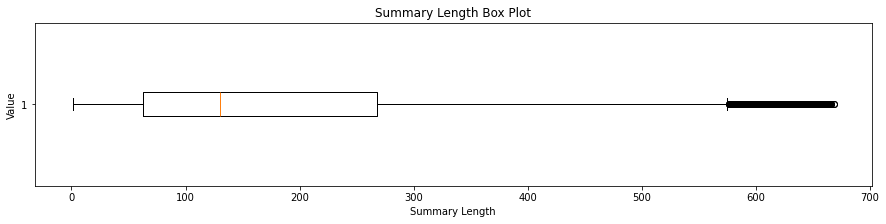

In [ ]:
# Analyze summary length
summary_stats = data['Summary_Length'].describe()
print(f"\nSummary length statistics:\n{summary_stats}")

# box plot for summary length
plt.figure(figsize=(15, 3))
# Creating the box plot
plt.boxplot(data['Summary_Length'], vert=False)
plt.title('Summary Length Box Plot')
plt.xlabel('Summary Length')
plt.ylabel('Value')
plt.show()


Publication year statistics:
count    15593.000000
mean      1986.779581
std         42.171144
min        398.000000
25%       1982.000000
50%       2004.000000
75%       2007.000000
max       2013.000000
Name: Publication year, dtype: float64


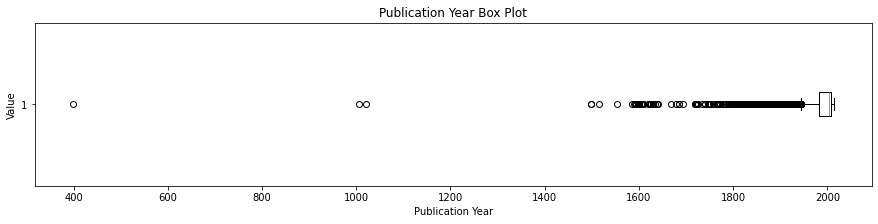

In [ ]:
# Analyze publication year
publication_stats = data['Publication_Year'].describe()
print(f"\nPublication year statistics:\n{publication_stats}")

# box plot for publication year
plt.figure(figsize=(15, 3))
# Creating the box plot
plt.boxplot(data['Publication_Year'], vert=False)
plt.title('Publication Year Box Plot')
plt.xlabel('Publication Year')
plt.ylabel('Value')
plt.show()


Genre distribution:
Fiction                4401
Speculative fiction    3995
Unknown                3552
Science Fiction        2675
Novel                  2312
                       ... 
Popular culture           1
Neuroscience              1
Alien invasion            1
Comedy of manners         1
Pastiche                  1
Length: 223, dtype: int64


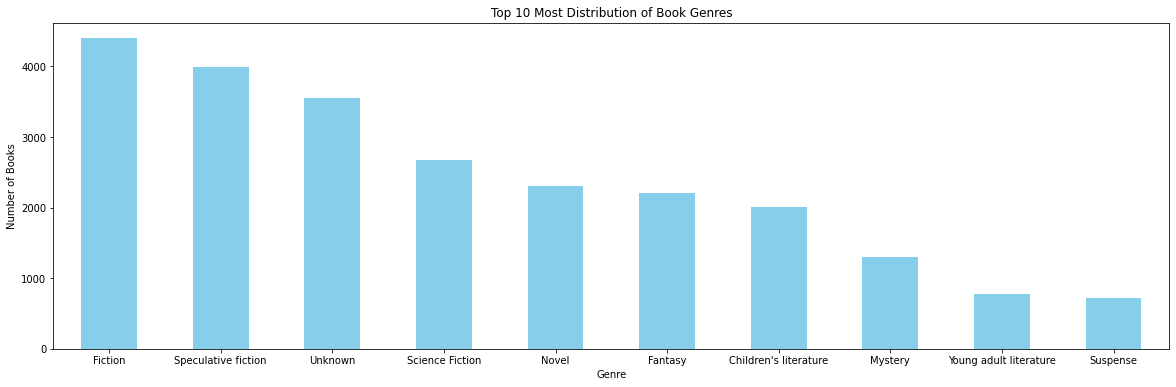

In [ ]:
# Genre distribution
genre_counts = get_genres_distribution(data)
print(f"\nGenre distribution:\n{genre_counts}")

# Get the top 10 most frequent genres
top_genres = genre_counts.head(10)

# Plot genre distribution
plt.figure(figsize=(20, 6))
top_genres.plot(kind='bar', color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Books')
plt.title('Top 10 Most Distribution of Book Genres')
plt.xticks(rotation=0)
plt.show()


Publication year distribution:

Publication year
2007.0    5756
2006.0     422
2008.0     366
2005.0     362
2004.0     338
          ... 
1590.0       1
1768.0       1
1621.0       1
1516.0       1
1640.0       1
Name: count, Length: 264, dtype: int64


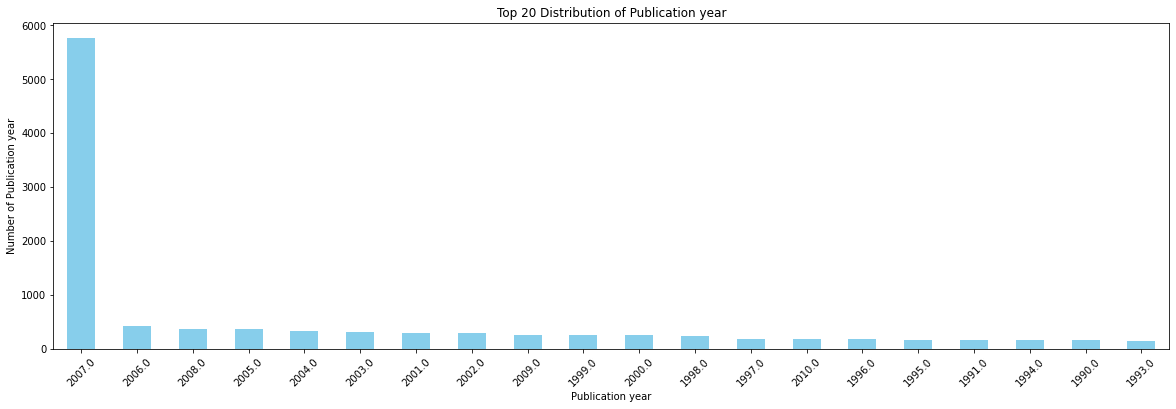

In [ ]:
# Publication year distribution
year_counts = data['Publication_Year'].value_counts()
print(f"\nPublication year distribution:\n\n{year_counts}")

# Get the top 20 most frequent publication year
top_years = year_counts.head(20)

# Plot publication year distribution
plt.figure(figsize=(20, 6))
top_years.plot(kind='bar', color='skyblue')
plt.xlabel("Publication year")
plt.ylabel("Number of Publication year")
plt.title("Top 20 Distribution of Publication year")
plt.xticks(rotation=45)
plt.show()


Author analysis:

Author
Unknown                 2294
Franklin W. Dixon         67
K. A. Applegate           60
Agatha Christie           58
Edgar Rice Burroughs      57
                        ... 
Mary Cheney                1
Nick Enright               1
Sion Sono                  1
Ntozake Shange             1
Stephen Colbert            1
Name: count, Length: 4553, dtype: int64


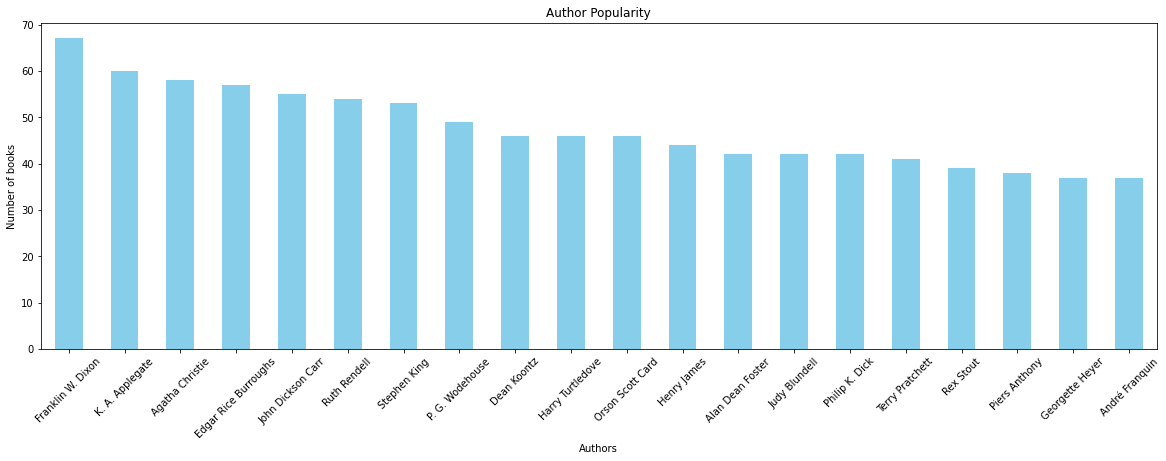

In [ ]:
# Author analysis
author_counts = data['Author'].value_counts()
print(f"\nAuthor analysis:\n\n{author_counts}")

# Get the top 20 most frequent authors
top_authors = author_counts.head(21)[1:]  # remove the Unknown author

# Plot most frequent authors
plt.figure(figsize=(20, 6))
top_authors.plot(kind='bar', color='skyblue')
plt.xlabel("Authors")
plt.ylabel("Number of books")
plt.title("Author Popularity")
plt.xticks(rotation=45)
plt.show()

(Science Fiction, Speculative fiction)    1860
(Speculative fiction, Fiction)            1829
(Speculative fiction, Fantasy)            1186
(Children's literature, Fiction)          1037
(Science Fiction, Fiction)                1001
(Fantasy, Fiction)                         941
(Mystery, Fiction)                         802
(Fiction, Novel)                           745
(Fiction, Suspense)                        620
(Mystery, Suspense)                        613
Name: count, dtype: int64


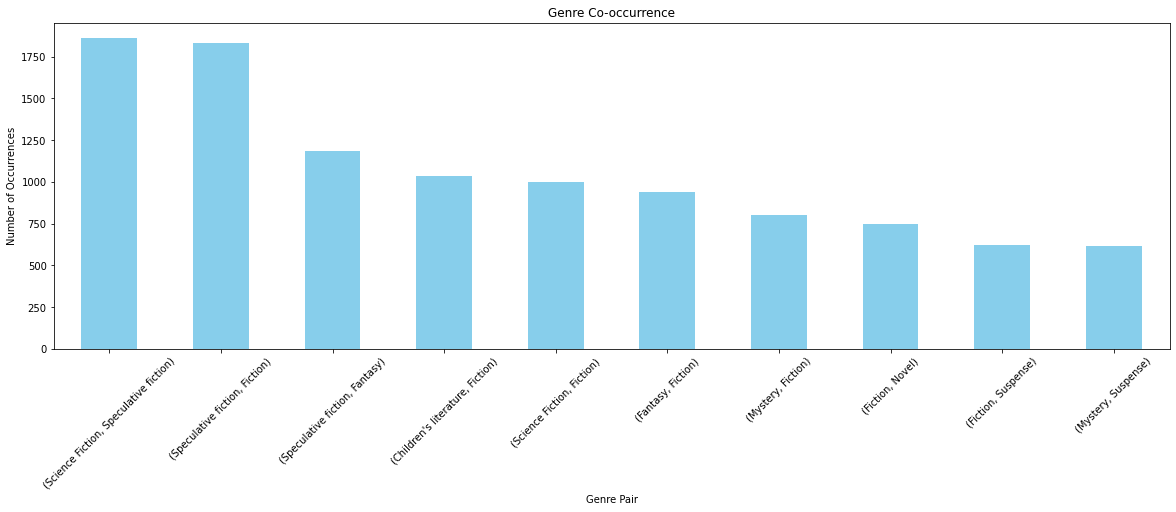

In [ ]:
# Genre Co-occurrence analysis
genre_pairs = []
for genres in data['Book_Genres']:
    for i in range(len(genres) - 1):
        for j in range(i + 1, len(genres)):
            pair = (genres[i], genres[j])
            genre_pairs.append(pair)

# Count occurrences
genre_pair_counts = pd.Series(genre_pairs).value_counts()

# Print top 10 most frequent genre pairs
most_frequent_genre_pairs = genre_pair_counts.head(10)
print(most_frequent_genre_pairs)

# Plot most frequent genre co-occurrence
plt.figure(figsize=(20, 6))
most_frequent_genre_pairs.plot(kind='bar', color='skyblue')
plt.xlabel("Genre Pair")
plt.ylabel("Number of Occurrences")
plt.title("Genre Co-occurrence")
plt.xticks(rotation=45)
plt.show()